This notebook is meant to study the spinup of the various model setup

In [1]:
from scipy.io import netcdf
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
#xlabel, ylabel, legend, savefig, colorbar, title, clim, pcolor, cm, contourf
import os
import csv
import sys
import glob
from netCDF4 import Dataset

from IPython.display import display, Math, Latex, Image
from mpl_toolkits.basemap import Basemap
import mpl_toolkits

sys.path.append('/noc/users/am8e13/PyNGL-1.4.0/lib/python2.7/site-packages/PyNGL/')
import Ngl
sys.path.append('/noc/users/am8e13/Python/')
import komod
sys.path.append('/noc/users/am8e13/Python/PyNIO-1.4.0/')
import Nio

from python_functions import *
import cmocean
import random
import calendar

from IPython.html.widgets import interact, interactive
from IPython.display import clear_output, display, HTML

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
:0: FutureWarning: IPython widgets are experimental and may change in the future.


/noc/users/am8e13/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:287: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


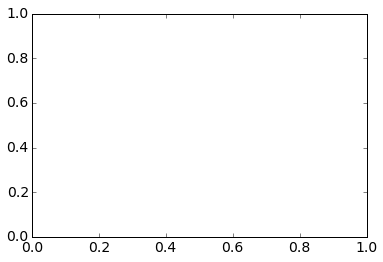

In [2]:
# Reading the Noaa file
woa = Woa()
mix = mxld_dic()
nsidc = read_seaicedata()

In [1]:
def fluxesCalculation_allin(run,times):
    kdic = {36:1,18:2,9:4}
    kk = kdic[run.res]

    file2read = netcdf.NetCDFFile('/scratch/general/am8e13/results'+str(run.res)+'km/grid.nc','r')
    hfacc = file2read.variables['HFacC']
    hfacc = hfacc[:]*1
    drf = file2read.variables['drF']
    drf = drf[:]*1
    rA = file2read.variables['rA']
    rA = rA[:]*1
    dyF = file2read.variables['dyF']
    dyF = dyF[:]*1
    dxF = file2read.variables['dxF']
    dxF = dxF[:]*1
    dydx = np.zeros_like(hfacc)
    for k in range(len(drf)):
        dydx[k,:,:] = drf[k]*rA*hfacc[k,:,:]
    Area_x = dydx/dxF
    Area_y = dydx/dyF
    Area_x[hfacc==0]=np.nan
    Area_y[hfacc==0]=np.nan
    
    coords = {'Fram': [58,80,76,76], 'Fram1' : [55,85,78,78] , 'Fram2' : [60,83,72,72] , \
              'Denmark': [100,100,37,48] , 'Bering' : [80,89,178,178] , 'Davis' : [113,135,75,75] ,\
              'Davis1' : [135,135,52,73] , 'Davis2' : [113,135,75,75],\
             'Norwice' : [50,95,15,15], 'Norwice2' : [60,95,25,25],
              'Scotice1' : [89,89,10,31], 'Scotice2' : [90,90,10,31], 'Scotice3' : [91,91,10,31],
              'Scotice4' : [92,92,10,31],'Scotice5' : [93,93,10,31],'Scotice6' : [94,94,10,31],
              'Scotice7' : [95,95,10,31],} 
    ax_d = {'Fram': 3, 'Fram1' : 3 , 'Fram2' : 3 , 'Denmark': 2 , 'Bering' : 3 , \
            'Davis' : 3 , 'Davis1' : 2 , 'Davis2' : 3, 'Norwice': 3, 'Norwice2' : 3,'Scotice':2,'Scotice1':2,\
            'Scotice2':2,'Scotice3':2}
    vel = {'Fram': 'U', 'Fram1' : 'V' , 'Fram2' : 'V' , 'Denmark': 'U' , \
             'Bering' : 'V' , 'Davis' : 'U' , 'Davis1' : 'U' , 'Davis2' : 'U','Norwice':'V','Norwice2':'V',\
          'Scotice':'U','Scotice1':'U','Scotice2':'U','Scotice3':'U'}
    
    def coord_calc(coord):
        if coord[0] == coord[1]:
            coord[0] = coord[0]*kk
            coord[1] = coord[0]+1
            coord[2] = coord[2]*kk
            coord[3] = coord[3]*kk
        elif coord[2] == coord[3]:
            coord[0] = coord[0]*kk
            coord[1] = coord[1]*kk
            coord[2] = coord[2]*kk
            coord[3] = coord[2]+1
        return coord

    run.fluxes2 = {}
    file2read = netcdf.NetCDFFile('/scratch/general/am8e13/results18km/grid.nc','r')
    mask = file2read.variables['HFacC']
    mask = mask[:]*1
    mask = np.tile(mask,(len(times),1,1,1))
    
    for var in ['Fram','Fram1','Fram2','Denmark','Bering','Davis','Davis1','Davis2',\
                'Norwice','Norwice2','Scotice1','Scotice2','Scotice3','Scotice4','Scotice5','Scotice6','Scotice7']:
        coord = coords[var]
        coord = coord_calc(coord)
        run.fluxes2[var] = {'Flux' : np.zeros_like(mask[:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSum' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxInSum' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxOutSum' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxS' : np.zeros_like(mask[:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumS' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxT' : np.zeros_like(mask[:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumT' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxFW' : np.zeros_like(mask[:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumFW' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxFW1' : np.zeros_like(mask[:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumFW1' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxOverFlow' : np.zeros_like(mask[:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumOverFlow' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxTop' : [], 'FluxMid' : [] , 'FluxBot' : [], \
                            'FluxTopS' : [], 'FluxMidS' : [] , 'FluxBotS' : [], \
                            'FluxTopT' : [], 'FluxMidT' : [] , 'FluxBotT' : []}
        
    S0 = 34.8
    rho0 = 1027.8

    for t,tt in enumerate(times):
        file2read = netcdf.NetCDFFile(run.path+'state.nc','r')
        S = file2read.variables['S']
        S = S[tt]*1
        T = file2read.variables['Temp']
        T = T[tt]*1
        vels = {}
        vels['U'] = file2read.variables['U']
        vels['U'] = vels['U'][tt]*1
        vels['V'] = file2read.variables['V']
        vels['V'] = vels['V'][tt]*1
        
        days = file2read.variables['T']
        days = days[tt]*1
        
        if t == 0:
            years = [0]
            days0 = days
        else:
            years.append((days - days0)/float(60*60*24*360)) 
            
        tmp1 = np.ones_like(mask[:,:,:,:])
        tmp1[:,S>S0] = 0
        
        tmp = np.ones_like(mask[:,:,:,:])
        tmp[:,31:,:,:] = 0
        
        tmpof = np.zeros_like(mask[:,:,:,:])
        tmpof[:,rhop(S,T)>rho0] = 1
        
        for var in ['Fram','Fram1','Fram2','Denmark','Bering','Davis','Davis1','Davis2',\
                    'Norwice','Norwice2','Scotice1','Scotice2','Scotice3','Scotice4','Scotice5','Scotice6','Scotice7']:
            coord = coords[var]
            coord = coord_calc(coord)

            run.fluxes2[var]['Flux'][t,:,:] = (vels[vel[var]][:,coord[0]:coord[1],coord[2]:coord[3]]*\
                    Area_y[:,coord[0]:coord[1],coord[2]:coord[3]]/10**6)
            run.fluxes2[var]['FluxSum'][t] = np.nansum(np.nansum(run.fluxes2[var]['Flux'][t,:,:]))
            run.fluxes2[var]['FluxInSum'][t] = np.nansum(np.nansum(run.fluxes2[var]['Flux'][t,run.fluxes2[var]['Flux'][t,:,:]>0]))
            run.fluxes2[var]['FluxOutSum'][t] = np.nansum(np.nansum(run.fluxes2[var]['Flux'][t,run.fluxes2[var]['Flux'][t,:,:]<0]))
            run.fluxes2[var]['FluxT'][t,:,:] = np.tile(run.fluxes2[var]['Flux'][t,:,:]*\
                                                T[:,coord[0]:coord[1],coord[2]:coord[3]],(1,1,1,1))
            run.fluxes2[var]['FluxSumT'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxT'][t,:,:]))
            run.fluxes2[var]['FluxS'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                                                S[:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumS'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxS'][t,:,:])) 
            run.fluxes2[var]['FluxFW'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                    (1 - S[:,coord[0]:coord[1],coord[2]:coord[3]]/S0)*tmp[t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumFW'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxFW'][t,:,:]))                 
            run.fluxes2[var]['FluxFW1'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                    (1 - S[:,coord[0]:coord[1],coord[2]:coord[3]]/S0)*tmp1[t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumFW1'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxFW1'][t,:,:]))   
            run.fluxes2[var]['FluxOverFlow'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*tmpof[t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumOverFlow'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxOverFlow'][t,:,:]))  
            
        if tt % 10 == 0:
            print 'We are at iteration {}'.format(tt)
    
    for var in ['Fram','Fram1','Fram2','Denmark','Bering','Davis','Davis1','Davis2',\
                'Norwice','Norwice2','Scotice1','Scotice2','Scotice3','Scotice4','Scotice5','Scotice6','Scotice7']:
        for flux in ['Flux','FluxT','FluxS','FluxFW','FluxFW1','FluxOverFlow']:
            run.fluxes2[var][flux] = np.squeeze(run.fluxes2[var][flux],axis=ax_d[var])
            
    for flux in ['FluxSumFW1', 'FluxInSum', 'FluxOverFlow', 'FluxSumFW','FluxSum', 'FluxFW1',
                 'Flux','FluxSumT','FluxS','FluxT','FluxFW','FluxOutSum','FluxSumOverFlow']:
        run.fluxes2['Scotice_ave'][flux] = (run.fluxes2['Scotice1'][flux] + run.fluxes2['Scotice2'][flux] + \
                                            run.fluxes2['Scotice3'][flux] + run.fluxes2['Scotice4'][flux] + \
                                            run.fluxes2['Scotice5'][flux] + run.fluxes2['Scotice6'][flux] + \
                                            run.fluxes2['Scotice7'][flux])/7.
    run.years = np.array(years)

In [3]:
# Read ERA data
ERA_36 = RunRead()
ERA_36.getPath('/hpcdata/scratch/am8e13/cs_36km_tutorial/run_spinup_ERA/results/')
#ERA_36.readMonitorData([0,777600,1555200,2332800,3110400,3888000,4665600,5443200])
#ERA_36.readMonitorSeaiceData([0,777600,1555200,2332800,3110400,3888000,4665600,5443200])
#ERA_36.readDynStData(7,[0,777600,1555200,2332800,3110400,3888000,4665600,5443200])
ERA_36.readStateData(range(720-12,720,1))
ERA_36.baroCalc()
#ERA_36.mxldepthread(range(12))
#ERA_36.seaiceread(range(12))
#ERA_36.fluxCalc()
ERA_36.title('ERA 36km','purple')

Read Monitor
Read Seaice Monitor
Read StDyn data


In [4]:
CORE_36 = RunRead()
CORE_36.getPath('/hpcdata/scratch/am8e13/cs_36km_tutorial/run_spinup_CORE_runofffixed/results/')
#CORE_36.readMonitorData([0,777600,1555200,2332800,3110400,3888000,4665600,5443200])
#CORE_36.readMonitorSeaiceData([0,777600,1555200,2332800,3110400,3888000,4665600,5443200])
#CORE_36.readDynStData(7,[0,777600,1555200,2332800,3110400,3888000,4665600,5443200])
CORE_36.readStateData(range(720-12,720,1))
CORE_36.baroCalc()
CORE_36.mxldepthread(range(12))
#CORE_36.seaiceread(range(12))
#CORE_36.fluxCalc()
CORE_36.title('CORE 36km','red')

Read Monitor
Read Seaice Monitor
Read StDyn data


In [ ]:
end

In [ ]:
mixed_36 = RunRead()
mixed_36.getPath('/hpcdata/scratch/am8e13/cs_36km_tutorial/run_mixed_CORE_ERA/results/')
mixed_36.readMonitorData([0,777600,1555200,2332800,3110400,3888000,4665600])
mixed_36.readMonitorSeaiceData([0,777600,1555200,2332800,3110400,3888000,4665600])
mixed_36.readDynStData(11,[0,777600,1555200,2332800,3110400,3888000,4665600])
#mixed_36.readStateData(range(720-12,720,1))
mixed_36.baroCalc()
mixed_36.mxldepthread(range(12))
mixed_36.seaiceread(range(12))
mixed_36.fluxCalc()
mixed_36.title('mixed 36km','black')

In [5]:
CORE_18 = RunRead()
CORE_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/run_spinup_CORE/results/')
CORE_18.readMonitorData([0,345600,691200,1036800,1382400,1728000,2073600,2419200,\
                                2764800,3110400,3456000,3801600,4147200,4492800,4838400])
CORE_18.readMonitorSeaiceData([0,345600,691200,1036800,1382400,1728000,2073600,2419200,\
                                2764800,3110400,3456000,3801600,4147200,4492800,4838400])
CORE_18.readDynStData(7,[0,345600,691200,1036800,1382400,1728000,2073600,2419200,\
                                2764800,3110400,3456000,3801600,4147200,4492800,4838400])
#CORE_18.readStateData(range(240-12,240,1))
#CORE_18.baroCalc()
#CORE_18.fluxCalc()
#CORE_18.mxldepthread(range(12))
#CORE_18.seaiceread(range(12))
CORE_18.title('CORE 18km','cyan')

Read Monitor
Read Seaice Monitor
Read StDyn data


In [6]:
CORE_9_nogm = RunRead()
CORE_9_nogm.getPath('/hpcdata/scratch/am8e13/run_template_9km/run_spinup_core_nogm/results/')
CORE_9_nogm.readMonitorData([0,138240,276480,414720,552960,691200,829440,967680,1105920,1244160,1382400,1520640,\
                             1658880,1797120,1935360,2073600,2211840,2350080,2488320,2626560,2764800,2903040,3041280,\
                            3179520,3317760,3456000,3594240,3732480,3870720,4008960,4147200])
CORE_9_nogm.readMonitorSeaiceData([0,138240,276480,414720,552960,691200,829440,967680,1105920,1244160,1382400,1520640,\
                             1658880,1797120,1935360,2073600,2211840,2350080,2488320,2626560,2764800,2903040,3041280,\
                            3179520,3317760,3456000,3594240,3732480,3870720,4008960,4147200])
CORE_9_nogm.readDynStData(7,[0,138240,276480,414720,552960,691200,829440,967680,1105920,1244160,1382400,1520640,\
                             1658880,1797120,1935360,2073600,2211840,2350080,2488320,2626560,2764800,2903040,3041280,\
                            3179520,3317760,3456000,3594240,3732480,3870720,4008960,4147200])
#CORE_9_nogm.readStateData(range(48-12,48,1))
#CORE_9_nogm.baroCalc()
#CORE_9_nogm.mxldepthread(range(12))
#CORE_9_nogm.seaiceread(range(12))
#CORE_9_nogm.fluxCalc()
CORE_9_nogm.title('CORE 9km','green')

Read Monitor
Read Seaice Monitor
Read StDyn data


In [183]:
def lit_data():
    class fluxes():
        def __init__(self):
            self.totalFluxes = {}
            self.title = []
    liq10 = fluxes()
    liq10.totalFluxes = {
             'Fram' : {'Inflow' : 3.9, 'Outflow' : -5.5, 'Total flow' : -1.6 , 'FWFlux' : -47.6, 'HFlux':24.4} ,
             'Fram1' : {'Inflow' : 3.9, 'Outflow' : -5.5, 'Total flow' : -1.6, 'FWFlux': -47.6, 'HFlux':24.4} ,
             'Fram2' : {'Inflow' : 3.9, 'Outflow' : -5.5, 'Total flow' : -1.6, 'FWFlux' : -47.6, 'HFlux':24.4} ,
             'Barents' : {'Inflow' : -1.2, 'Outflow' : 4.1, 'Total flow' :2.9, 'FWFlux':-8.1, 'HFlux':71.6} ,
             'Barents1' : {'Inflow' : -1.2, 'Outflow' : 4.1, 'Total flow' :2.9, 'FWFlux':-8.1, 'HFlux':71.6} ,
             'Barents2' : {'Inflow' : -1.2, 'Outflow' : 4.1, 'Total flow' :2.9, 'FWFlux' :-8.1, 'HFlux':71.6} ,
             'Bering': {'Inflow' : 1.3, 'Outflow' : 0.0, 'Total flow' :1.3, 'FWFlux' :95.2,'HFlux':5.4} ,
             'Davis': {'Inflow' : 0.6, 'Outflow' : -3.2, 'Total flow' :-2.6, 'FWFlux' :-123.8, 'HFlux':12.6},
             'Davis2': {'Inflow' : 0.6, 'Outflow' : -3.2, 'Total flow' :-2.6, 'FWFlux' :-123.8, 'HFlux':12.6},
             'Davis1': {'Inflow' : 0.6, 'Outflow' : -3.2, 'Total flow' :-2.6, 'FWFlux' :-123.8, 'HFlux':12.6}
            }
    liq10.color = 'blue'
    liq10.title = "Lique10"
    
    core2 = fluxes()
    core2.totalFluxes =  {
             'Fram' : {'Inflow' : 0, 'Outflow' : 0, 'Total flow' : -1.95, 'FWFlux' : 0.0, 'HFlux':53.96,'Error':2.3} ,
             'Fram1' : {'Inflow' : 0, 'Outflow' : 0, 'Total flow' : -1.95, 'FWFlux' : 0.0, 'HFlux':53.96,'Error':2.3} ,
             'Fram2' : {'Inflow' : 0, 'Outflow' : 0, 'Total flow' : -1.95, 'FWFlux' : 0.0, 'HFlux':53.96,'Error':1.12} ,
             'Barents' : {'Inflow' : 0, 'Outflow' : 0, 'Total flow' : 2.53, 'FWFlux' : 0.0, 'HFlux':22.98,'Error':1.06} ,
             'Barents1' : {'Inflow' : 0, 'Outflow' : 0, 'Total flow' : 2.53, 'FWFlux' : 0.0, 'HFlux':22.98,'Error':1.06} ,
             'Barents2' : {'Inflow' : 0, 'Outflow' : 0, 'Total flow' : 2.53, 'FWFlux' : 0.0, 'HFlux':22.98,'Error':1.06} ,
             'Bering': {'Inflow' : 0, 'Outflow' :0, 'Total flow' : 0.99, 'FWFlux' : 0.0, 'HFlux': 3.39,'Error':0.3} ,
             'Davis': {'Inflow' : 0, 'Outflow' : 0, 'Total flow' :-1.75, 'FWFlux' : 0.0, 'HFlux':13.44,'Error':1.2},
             'Davis2': {'Inflow' : 0, 'Outflow' : 0, 'Total flow' :-1.75, 'FWFlux' : 0.0, 'HFlux':13.44,'Error':1.2},
             'Davis1': {'Inflow' : 0, 'Outflow' : 0, 'Total flow' :-1.75, 'FWFlux' : 0.0, 'HFlux':13.44,'Error':1.2} 
            }
    core2.title = "CORE2"
    core2.color = 'orange'

    obs = fluxes()
    obs.totalFluxes =   {'Fram' : {'Inflow' : 0, 'Outflow' : 0, 'Total flow' : -2.0, 'FWFlux' : 0.0, 'HFlux':70.0,'Error':-2.7} ,
             'Fram1' : {'Inflow' : 0, 'Outflow' : 0, 'Total flow' : -2.0, 'FWFlux' : 0.0, 'HFlux':70.0,'Error':-2.7} ,
             'Fram2' : {'Inflow' : 0, 'Outflow' : 0, 'Total flow' : -2.0, 'FWFlux' : 0.0, 'HFlux':70.0,'Error':-2.7} ,
             'Barents' : {'Inflow' : -1.2, 'Outflow' : 4.1, 'Total flow' : 2.15 , 'FWFlux' : 0.0, 'HFlux':'26-50','Error':0.15} ,
             'Barents1' : {'Inflow' : -1.2, 'Outflow' : 4.1, 'Total flow' :'2-2.3', 'FWFlux' : 0.0, 'HFlux':'26-50','Error':0.15} ,
             'Barents2' : {'Inflow' : -1.2, 'Outflow' : 4.1, 'Total flow' :'2-2.3', 'FWFlux' : 0.0, 'HFlux':'26-50','Error':0.15} ,
             'Bering': {'Inflow' : 0, 'Outflow' : 0, 'Total flow' :0.8, 'FWFlux' : 0.0, 'HFlux': 0.0,'Error':0.2} ,
             'Davis': {'Inflow' : 0, 'Outflow' : 0, 'Total flow' :-2.6, 'FWFlux' : 0.0, 'HFlux':19.0,'Error':1.0},
             'Davis2': {'Inflow' : 0, 'Outflow' : 0, 'Total flow' :-2.6, 'FWFlux' : 0.0, 'HFlux':19.0,'Error':1.0},
             'Davis1': {'Inflow' : 0, 'Outflow' : 0, 'Total flow' :-2.6, 'FWFlux' : 0.0, 'HFlux':19.0,'Error':1.0}
            }

    obs.title = "Observ"
    obs.color = "grey"
    return liq10,core2,obs
liq10,core2,obs = lit_data()

In [184]:
liq10,core2,obs = lit_data();
for var in ['Barents','Barents1','Barents2','Bering','Fram','Fram1','Fram2','Davis','Davis1']:
    print var
    print 'ERA_36',ERA_36.totalFluxes[var]
    print 'COR_36',CORE_36.totalFluxes[var]
    print 'mix_36',mixed_36.totalFluxes[var]
    print 'COR_18',CORE_18.totalFluxes[var]
    #print 'COR_9 ',CORE_9.totalFluxes[var]
    print 'COR9gm',CORE_9_nogm.totalFluxes[var]
    print 'liq10 ',liq10.totalFluxes[var]
    print 'Core2 ',core2.totalFluxes[var]
    print 'obsv  ',obs.totalFluxes[var]

Barents
ERA_36 {'HFlux': 0.1, 'Outflow': -0.75, 'Total flow': -0.04, 'FWFlux': -8.11, 'Inflow': 0.71}
COR_36 {'HFlux': -2.97, 'Outflow': -3.63, 'Total flow': -0.68, 'FWFlux': 3.68, 'Inflow': 2.95}
mix_36 {'HFlux': -3.31, 'Outflow': -4.26, 'Total flow': -0.36, 'FWFlux': 0.69, 'Inflow': 3.9}
COR_18 {'HFlux': -3.2, 'Outflow': -3.71, 'Total flow': -0.25, 'FWFlux': 7.09, 'Inflow': 3.46}
COR9gm {'HFlux': -3.88, 'Outflow': -4.02, 'Total flow': -0.91, 'FWFlux': 0.07, 'Inflow': 3.11}
liq10  {'HFlux': 71.6, 'Outflow': 4.1, 'Total flow': 2.9, 'FWFlux': -8.1, 'Inflow': -1.2}
Core2  {'Total flow': 2.53, 'FWFlux': 0.0, 'Outflow': 0, 'Error': 1.06, 'HFlux': 22.98, 'Inflow': 0}
obsv   {'Total flow': 2.15, 'FWFlux': 0.0, 'Outflow': 4.1, 'Error': 0.15, 'HFlux': '26-50', 'Inflow': -1.2}
Barents1
ERA_36 {'HFlux': -2.95, 'Outflow': -0.99, 'Total flow': -0.44, 'FWFlux': -14.12, 'Inflow': 0.55}
COR_36 {'HFlux': -2.62, 'Outflow': -3.17, 'Total flow': -0.31, 'FWFlux': 3.11, 'Inflow': 2.86}
mix_36 {'HFlux': -4.

In [82]:
# dpi resolution
dpires = 300

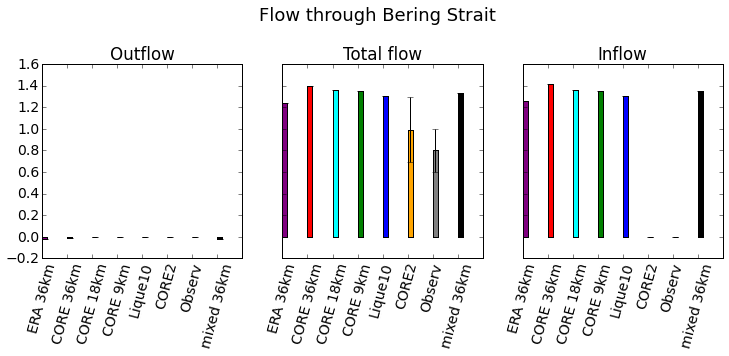

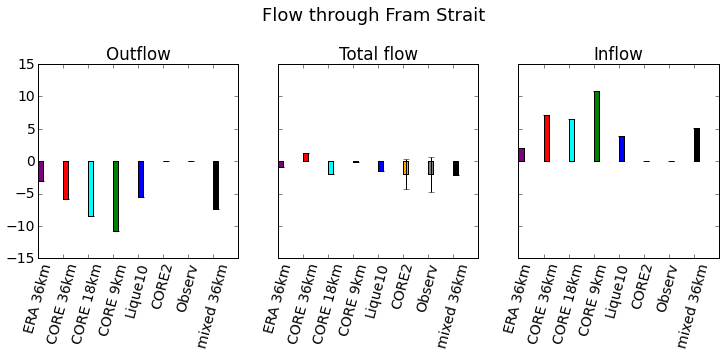

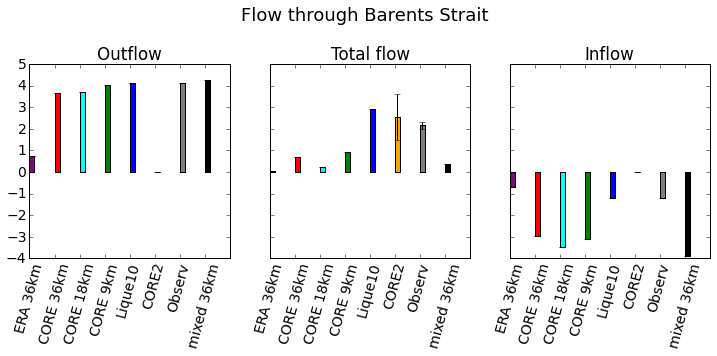

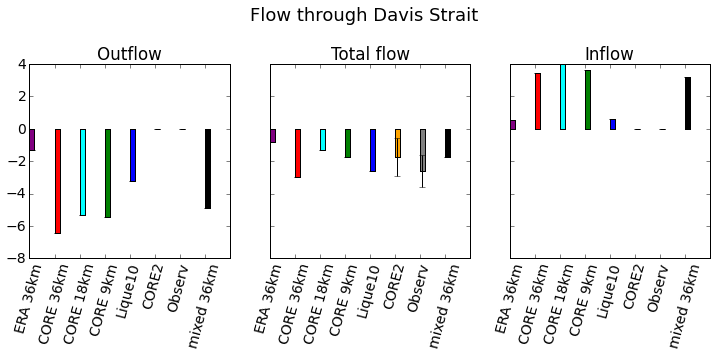

In [186]:
# the x locations for the groups
      # the width of the bars
comp_tot = {1 : ERA_36, 2 : CORE_36 ,8 :mixed_36, 3 : CORE_18 , 4 : CORE_9_nogm , 5 : liq10 , 6 : core2, 7 : obs }#, 7 : obs}
def flux_bar(comp_hist,var):
    width = 0.35 
    fluxes = [ 'Outflow' ,'Total flow' , 'Inflow' ]
    fig, axes = plt.subplots(ncols=len(fluxes),nrows=1,sharey=True)    
    ax_ind = 0
    for j in fluxes:#, 'HFlux' , 'FWFlux']:
        menMean = []
        xtick = []
        cols = []
        errStd = []
        for data in comp_hist:
            if var == 'Barents' and not((data == 5) or (data == 6) or (data == 7)):
                i = -1
            else:
                i = 1
            menMean.append(i*comp_hist[data].totalFluxes[var][j])
            if (data == 7 or data == 6) and (j == 'Total flow'):
                errStd.append(comp_hist[data].totalFluxes[var]['Error'])
            else:
                errStd.append(0)
            N = len(menMean)
            ind = np.arange(N)  
            xtick.append(comp_hist[data].title)
            cols.append(comp_hist[data].color)
        rects1 = axes.flat[ax_ind].bar(ind, menMean, width = 0.20 , color=cols,yerr=errStd,ecolor='black',)
        axes.flat[ax_ind].set_xticks(ind)
        axes.flat[ax_ind].set_xticklabels(xtick,rotation=75)
        axes.flat[ax_ind].set_title(j)
        fig.suptitle("Flow through "+var+" Strait",x=0.9,y=1.,fontsize=18)
        ax_ind += 1
    fig.subplots_adjust(right=1.7,top=0.8)
    #fig.savefig('/noc/users/am8e13/Figures/fluxes_'+var,dpi=dpires, bbox_inches='tight')
    
flux_bar(comp_tot,'Bering')   
flux_bar(comp_tot,'Fram')   
flux_bar(comp_tot,'Barents')   
flux_bar(comp_tot,'Davis')   

In [187]:
#comp_all = {0 : woa ,1 : ERA_36, 2 : CORE_36 , 3 : CORE_18 , 4 : CORE_9 , 5 : CORE_9_nogm}
comp_all = {0 : woa ,1 : ERA_36, 2 : CORE_36 , 3 : CORE_18 , 4 : CORE_9_nogm}

In [188]:
comp_diff = {1 : ERA_36, 2 : CORE_36 , 3 : CORE_18 , 4 : CORE_9_nogm}

In [189]:
comp_36 = {0 : woa ,1 : ERA_36, 2 : CORE_36}

In [190]:
comp_all = {0 : woa ,1 : ERA_36, 2 : CORE_36 , 3 : CORE_18 , 4 : mixed_36}
comp_diff = {1 : ERA_36, 2 : CORE_36 , 3 : CORE_18 , 4 : mixed_36}

In [191]:
#comp_core = {2 : CORE_36 , 3 : CORE_18 , 4 : CORE_9}

In [192]:
def comp_plot(data, reg,npoints=15):
    import matplotlib as mpl
    # This function plots time evolution of temperature/salinity on a transect.                                                    
    # Transect are: Fram Strait, Bering Strait ...     
    km_ticks = {"bering" : [ 0 , 100 , 200 , 300] , "fram" : [0 , 150 , 300 , 450] , "barents" : [ 0 , 200 , 400 , 600] ,
           "davis" : [0 , 100 , 200 , 300] , "denmark" : [0 , 100 , 200 , 300] , "norwice" : [0 , 100 , 200 , 300] ,\
                "arctic1" : [0 , 750 , 1500 , 2250], "arctic2" : [0,1000,2000,3000] ,
            "arctic3" : [0 , 750 , 1500 , 2250] , "arctic4" : [0 , 2000 , 4000 , 6000]}
                                                                                                               
    npl = len(data)                                                                                                                  
    regions = {"barents" : [77,-20,79,10] , "fram" : [80,-13,79,10] , "bering" : [64,-169,67,-168] , \
               "davis" : [66,-61,66,-53] , "denmark" : [67, -32 , 65, -23], "norwice" : [65 , -14 , 61 ,5], \
               "arctic1" : [83,-28,74,136] , "arctic2" : [71,-139,75,53], \
               "arctic3" : [78,-115,76,111] , "arctic4" : [60,180,60,0]}
    region = regions[reg]
    
    lat1 = region[0] ; lon1 = region[1] ; lat2 = region[2] ; lon2 = region[3] ;
    fig, axes = plt.subplots(3,npl,sharex='col', sharey='row')
    ind = 0

    t_min = -2 ; t_max = 8 ; tempbounds = np.linspace(t_min,t_max,15) ; tempbounds1 = np.linspace(t_min,t_max,5)
    s_min = 30 ; s_max = 35.5 ; saltbounds = np.linspace(s_min,s_max,15) ; saltbounds1 = np.linspace(s_min,s_max,5)
    r_min = 26 ; r_max = 29 ; rhobounds = np.linspace(r_min,r_max,15) ; rhobounds1 = np.linspace(r_min,r_max,5)

    for run in data:
        # plot temperature                                                                                                           
        data_prof, x_kilometers, m_grid, n_grid  = \
        get_transect1(data[run].lat, data[run].lon, data[run].T , lat1, lon1, lat2, lon2,\
                                                                 npoints = npoints, pdif = 1, norep=False)
        Z,z2 = lastnan(data_prof,data[run].depth)
        if ind == 0:
            imT = axes.flat[ind].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=t_min,vmax=t_max,levels = tempbounds,\
                    extend = 'both', cmap = cmocean.cm.temperature)
        else:
            axes.flat[ind].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=t_min,vmax=t_max,levels = tempbounds,\
                    extend = 'both', cmap = cmocean.cm.temperature)
                                                                           
        axes.flat[ind].set_title("Temp - "+data[run].title,fontsize=16)
        #axes.flat[ind].title.set_fontsize('16',fontsize=15)
        if ind == 0:
            axes.flat[ind].set_ylabel(r"m")

        # plot salinity                                                                                                              
        data_prof, x_kilometers, m_grid, n_grid  = \
        get_transect1(data[run].lat, data[run].lon, data[run].S , lat1, lon1, lat2, lon2,\
                                                                 npoints = npoints, pdif = 1, norep=False)
        if ind == 0:
            imS = axes.flat[ind+npl].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=s_min,vmax=s_max,levels = saltbounds,\
                    extend = 'both' , cmap = cmocean.cm.salt)
        else:
            axes.flat[ind+npl].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=s_min,vmax=s_max,levels = saltbounds,\
                    extend = 'both' , cmap = cmocean.cm.salt)
        axes.flat[ind+npl].set_title("Sal - "+data[run].title,fontsize=16)
        #axes.flat[ind+npl].title.set_fontsize('16')
        if ind == 0:
            axes.flat[ind+npl].set_ylabel(r"$m$",fontsize=15)

        # plot density                                                                                                               
        data_prof, x_kilometers, m_grid, n_grid  = \
        get_transect1(data[run].lat, data[run].lon, data[run].rhop - 1000 , lat1, lon1, lat2, lon2,\
                                                                 npoints = npoints, pdif = 1, norep=False)
        if ind == 0:
            imrho = axes.flat[ind+npl*2].contourf(x_kilometers,Z,data_prof[0:z2,:],\
                    vmin=r_min,vmax=r_max,levels = rhobounds,\
                    extend = 'both',cmap = cmocean.cm.rho)
        else:
            axes.flat[ind+npl*2].contourf(x_kilometers,Z,data_prof[0:z2,:],\
                    vmin=r_min,vmax=r_max,levels = rhobounds,\
                    extend = 'both',cmap = cmocean.cm.rho)                                                                                          
        axes.flat[ind+npl*2].set_title("Dens - "+data[run].title,fontsize=16)
        #axes.flat[ind+npl*2].title.set_fontsize('16')
        if ind == 0:
            axes.flat[ind+npl*2].set_ylabel(r'$m$',fontsize=15)
        axes.flat[ind+npl*2].set_xlabel(r'$km$',fontsize=15)

        # this is to plot ticks   
        ax = axes.flat[ind+npl].get_xaxis()
        ax.set_ticks(km_ticks[reg])                                                                                                            
        ind = ind + 1

    cbar_ax = fig.add_axes([2.15, 2.2, 0.045, 0.7])
    cbar = plt.colorbar(imT, cax=cbar_ax,ticks=[-1,0,1,2,3,4,5,6,7])
    cbar.ax.set_ylabel(r'$^{\circ}C$')

    cbar_ax2 = fig.add_axes([2.15, 1.2, 0.045, 0.7])
    cbar2 = plt.colorbar(imS, cax=cbar_ax2,ticks=[30,31,32,33,34,35])
    cbar2.ax.set_ylabel(r'$psu$')

    cbar_ax3 = fig.add_axes([2.15, 0.2, 0.045, 0.7])
    cbar3 = plt.colorbar(imrho, cax=cbar_ax3,ticks=[26.0,26.5,27.0,27.5,28.0,28.5,29])
    cbar3.ax.set_ylabel(r'$kg/m^3$')
    
    fig.subplots_adjust(right=2.1,top=3.)
    #fig.savefig('/noc/users/am8e13/Figures/transect_'+reg,dpi=dpires, bbox_inches='tight')

Bering Strait

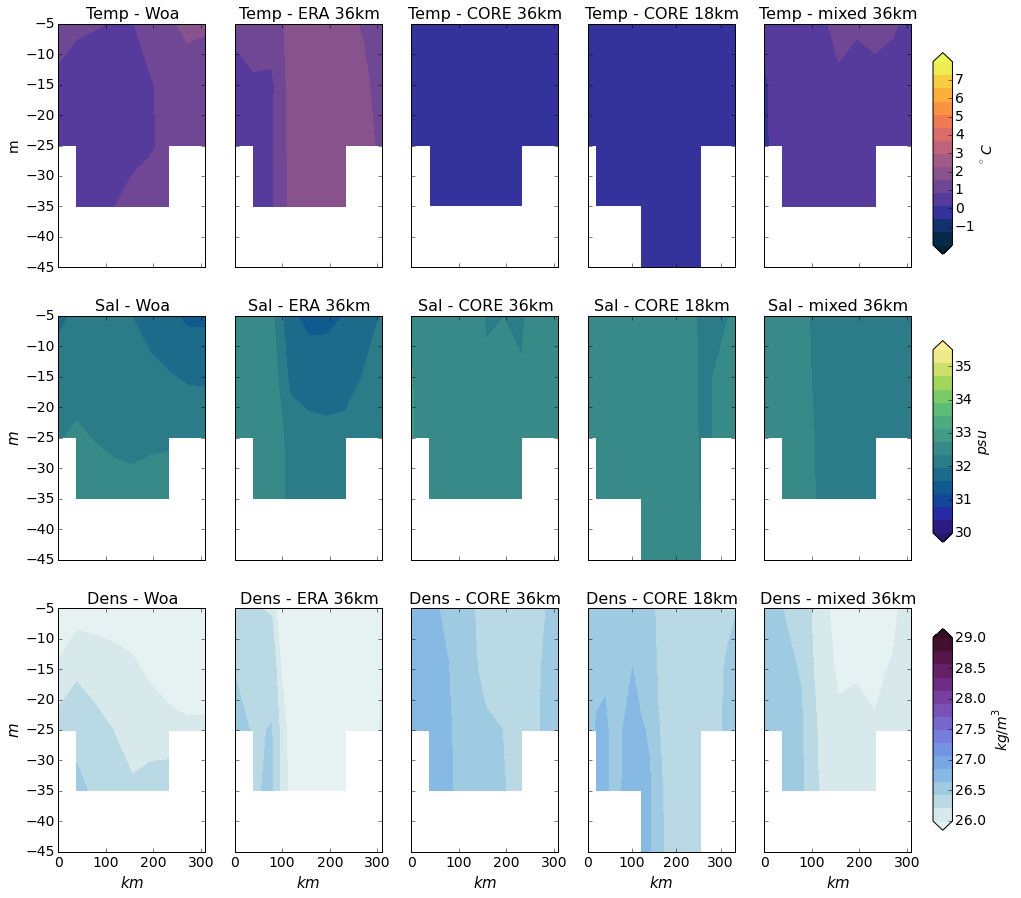

In [193]:
comp_plot(comp_all,"bering")

Fram Strait

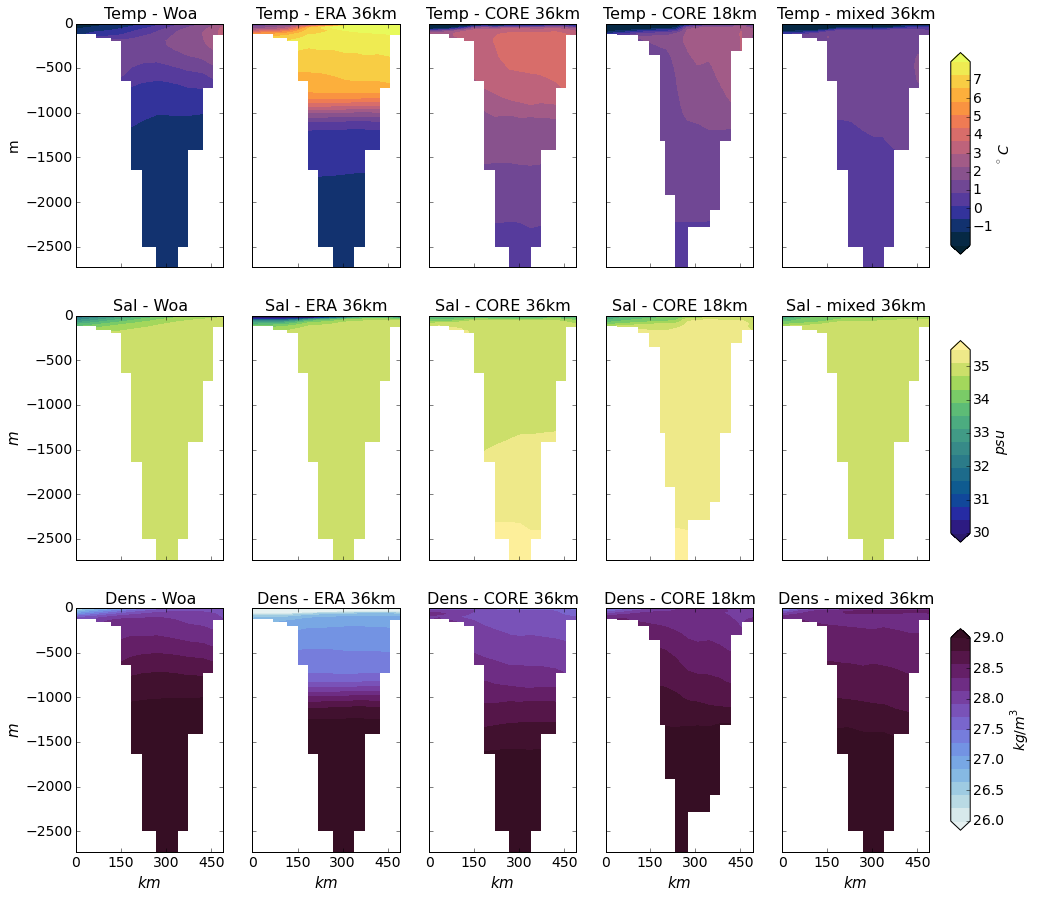

In [194]:
comp_plot(comp_all,'fram')

Barents Strait

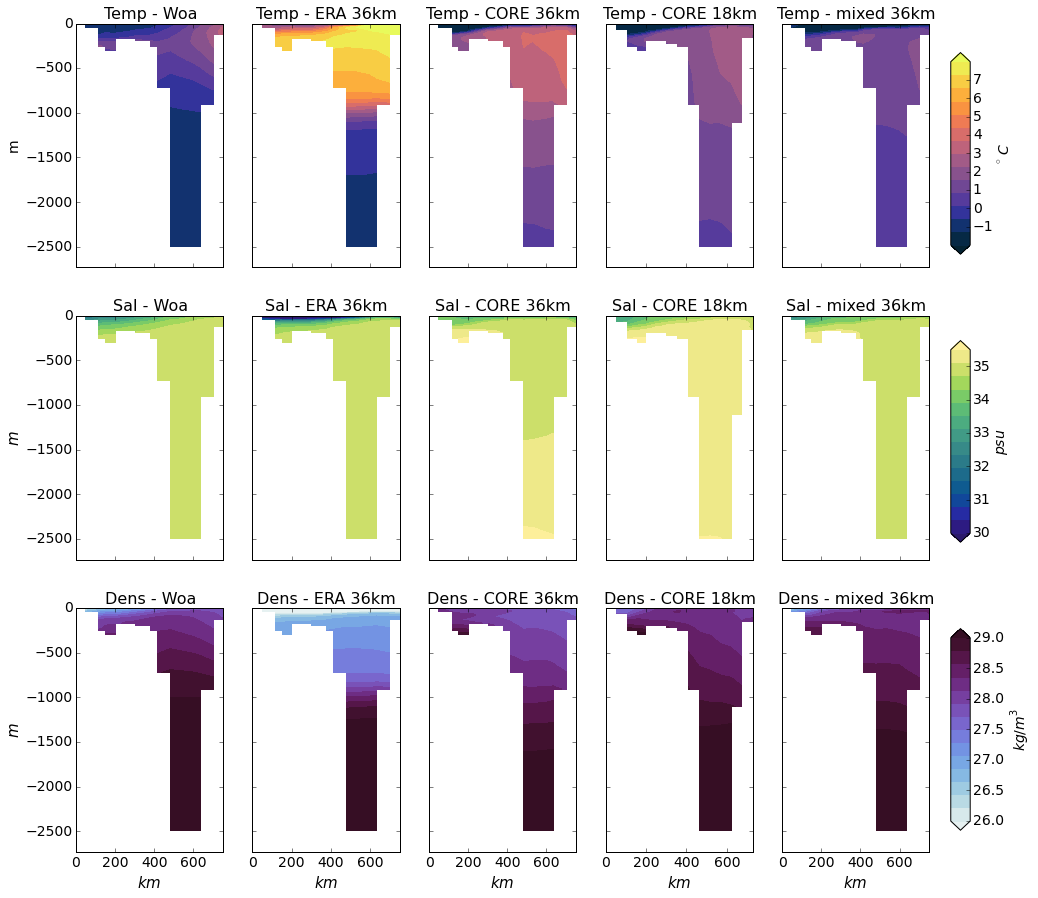

In [195]:
comp_plot(comp_all,"barents")

Davis Strait

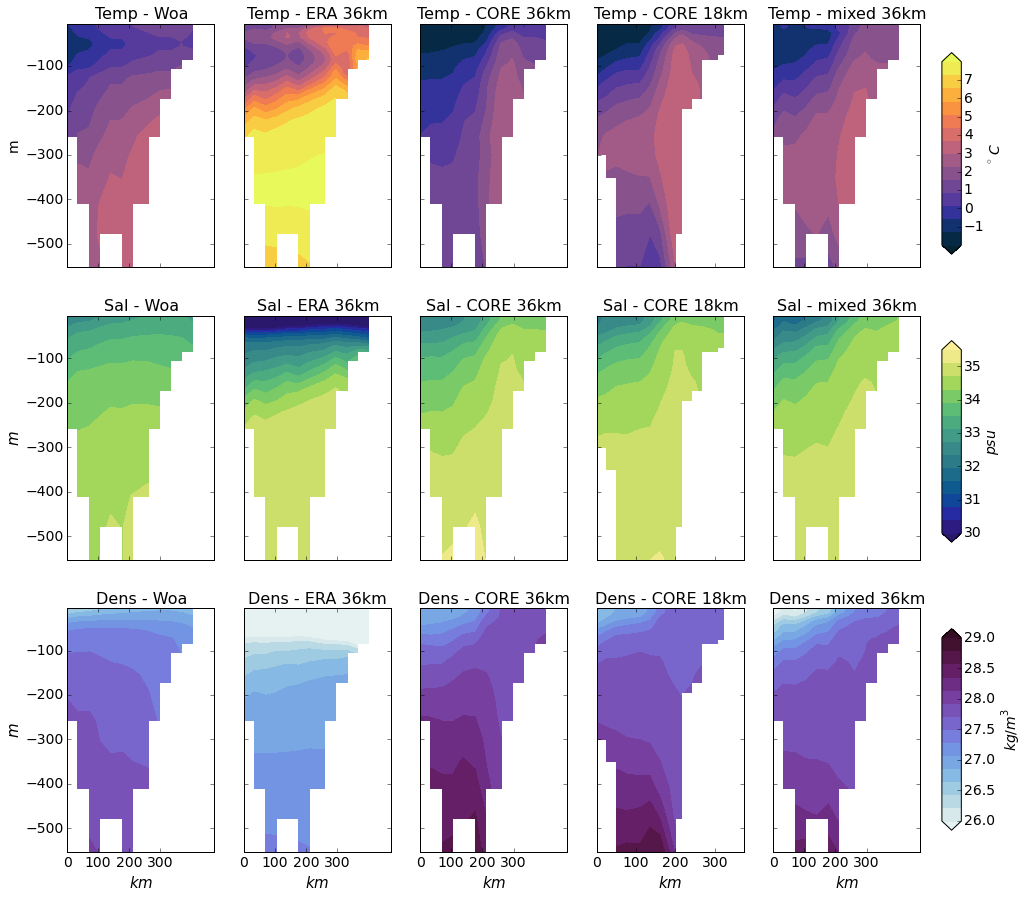

In [196]:
comp_plot(comp_all,"davis")

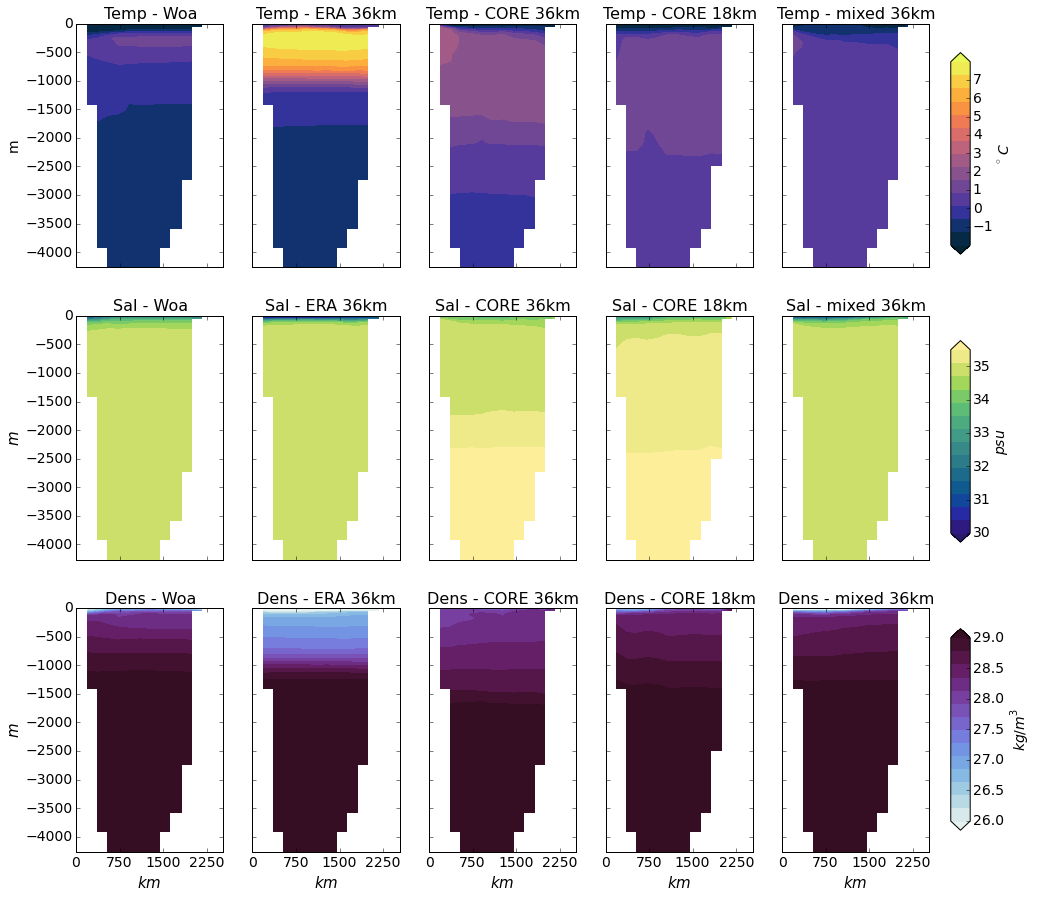

In [197]:
comp_plot(comp_all,"arctic1")

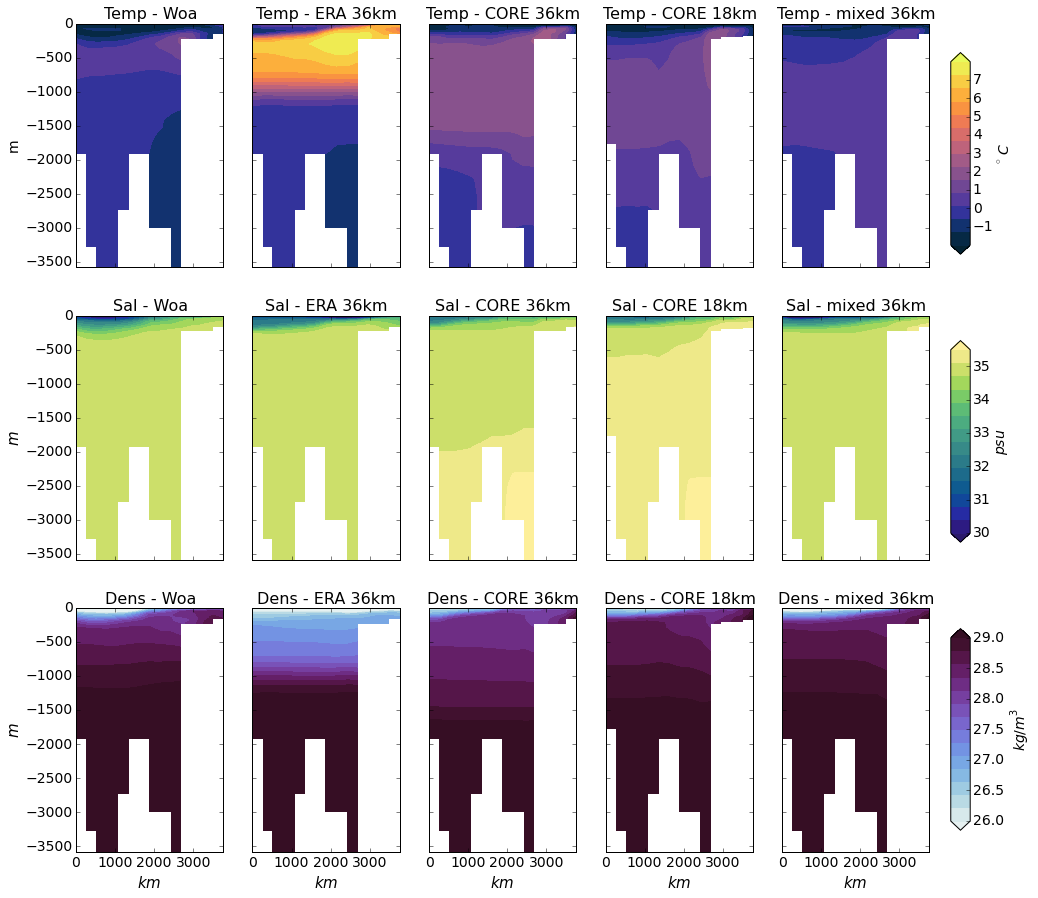

In [198]:
comp_plot(comp_all,"arctic2")

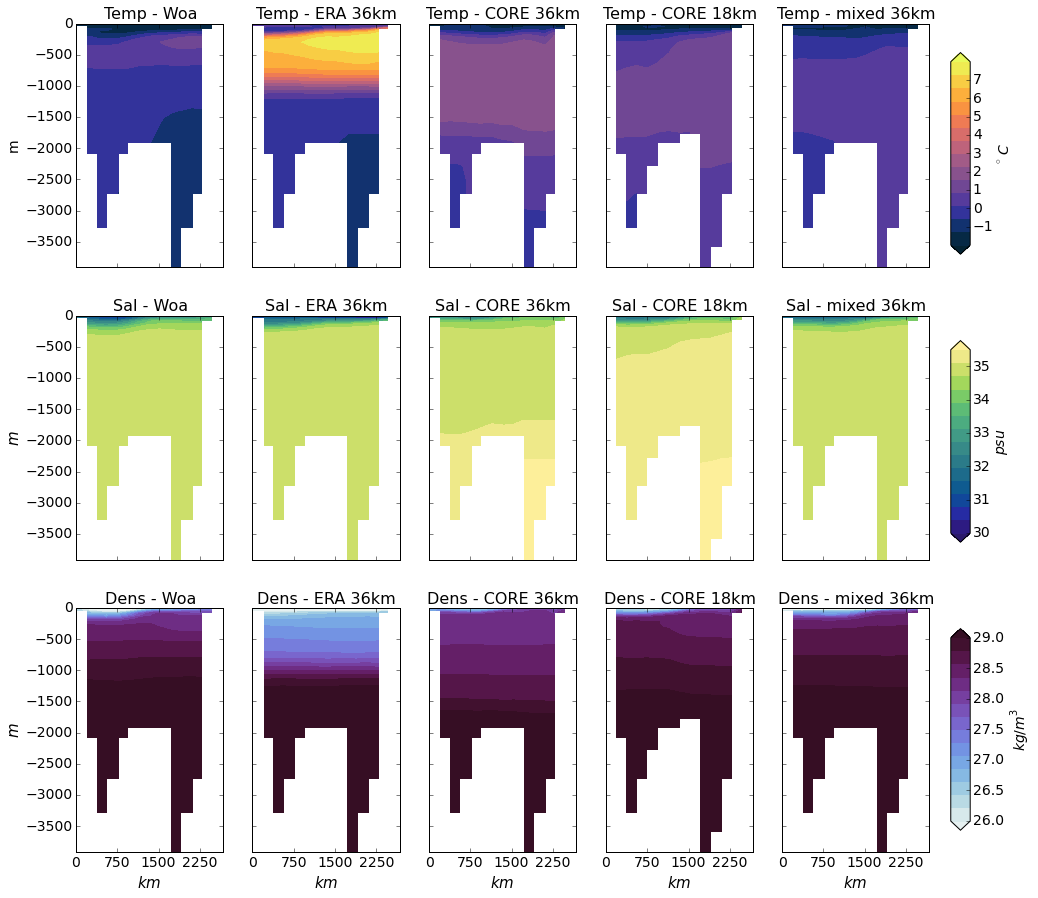

In [199]:
comp_plot(comp_all,"arctic3")

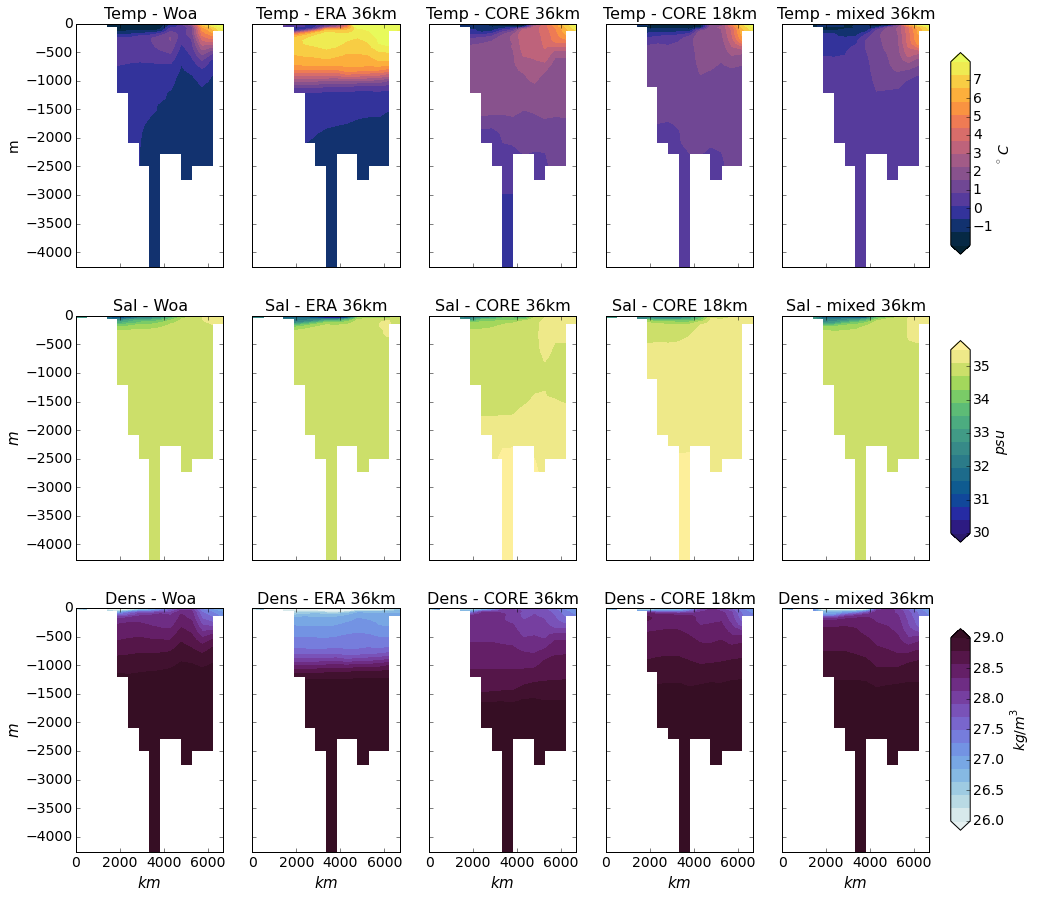

In [200]:
comp_plot(comp_all,"arctic4")

In [201]:
def comp_diff_plot(data,diff, reg,npoints=15):
    import matplotlib as mpl
    # This function plots time evolution of temperature/salinity on a transect. 
    # Transect are: Fram Strait, Bering Strait ...            
    km_ticks = {"bering" : [ 0 , 100 , 200 , 300] , "fram" : [0 , 150 , 300 , 450] , "barents" : [ 0 , 200 , 400 , 600] ,
           "davis" : [0 , 100 , 200 , 300] , "arctic1" : [0 , 750 , 1500 , 2250], "arctic2" : [0,1000,2000,3000] ,
            "arctic3" : [0 , 750 , 1500 , 2250] , "arctic4" : [0 , 2000 , 4000 , 6000]}
    
    npl = len(data)
    regions = {"barents" : [77,-20,79,10] , "fram" : [80,-13,79,10] , "bering" : [64,-169,67,-168] , \
               "davis" : [66,-61,66,-53] , "arctic1" : [83,-28,74,136] , "arctic2" : [71,-139,75,53], \
               "arctic3" : [78,-115,76,111] , "arctic4" : [60,180,60,0] }
    region = regions[reg]

    lat1 = region[0]
    lon1 = region[1]
    lat2 = region[2]
    lon2 = region[3]
    fig, axes = plt.subplots(3,npl,sharex='col', sharey='row')
    ind = 0

    t_min = -3 ; t_max = 3 ; tempbounds = np.linspace(t_min,t_max,15) ; tempbounds1 = np.linspace(t_min,t_max,5)
    s_min = -2 ; s_max = 2 ; saltbounds = np.linspace(s_min,s_max,15) ; saltbounds1 = np.linspace(s_min,s_max,5)
    r_min = -1 ; r_max = 1 ; rhobounds = np.linspace(r_min,r_max,15) ; rhobounds1 = np.linspace(r_min,r_max,5)

    for run in data:
        # plot temperature   
        if data[run].res == 36:
            diffT = np.array(diff.T)
            diffS = np.array(diff.S)
            diffrhop = np.array(diff.rhop)
        elif data[run].res == 18:
            diffT = np.array(diff.T18)
            diffS = np.array(diff.S18)
            diffrhop = np.array(diff.rhop18) 
        elif data[run].res == 9:
            diffT = np.array(diff.T9)
            diffS = np.array(diff.S9)
            diffrhop = np.array(diff.rhop9) 
        
        data_prof, x_kilometers, m_grid, n_grid  = \
        get_transect1(data[run].lat, data[run].lon, data[run].T - diffT , lat1, lon1, lat2, lon2,\
                                                                 npoints = npoints, pdif = 1, norep=False)
        Z,z2 = lastnan(data_prof,data[run].depth)
        if ind == 0:
            imT = axes.flat[ind].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=t_min,vmax=t_max,levels = tempbounds,\
                    extend = 'both', cmap = cmocean.cm.freesurface)
        else:
            #print x_kilometers.shape,Z.shape,data_prof[0:z2,:].shape,run
            axes.flat[ind].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=t_min,vmax=t_max,levels = tempbounds,\
                    extend = 'both', cmap = cmocean.cm.freesurface)
        #axes.flat[ind].contour(x_kilometers,Z,data_prof[0:z2,:],colors='k',levels = tempbounds1,\                                    
        #            extend = 'both')                                                                                                 
        axes.flat[ind].set_title("Temp - "+data[run].title,fontsize=16)
        axes.flat[ind].title.set_fontsize('16')
        if ind == 0:
            axes.flat[ind].set_ylabel(r'$m$',fontsize=15)

        # plot salinity                                                                                                               
        data_prof, x_kilometers, m_grid, n_grid  = \
        get_transect1(data[run].lat, data[run].lon, data[run].S - diffS, lat1, lon1, lat2, lon2,\
                                                                 npoints = npoints, pdif = 1, norep=False)
        
        if ind == 0:
            imS = axes.flat[ind+npl].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=s_min,vmax=s_max,levels = saltbounds,\
                    extend = 'both' , cmap = cmocean.cm.freesurface)
        else:
            axes.flat[ind+npl].contourf(x_kilometers,Z,data_prof[0:z2,:],vmin=s_min,vmax=s_max,levels = saltbounds,\
                    extend = 'both' , cmap = cmocean.cm.freesurface)
        #axes.flat[ind+npl].contour(x_kilometers,Z,data_prof[0:z2,:],colors='k',levels = saltbounds1,\                                
        #            extend = 'both')                                                                                                 
        axes.flat[ind+npl].set_title("Sal - "+data[run].title,fontsize=16)
        axes.flat[ind+npl].title.set_fontsize('16')
        if ind == 0:
            axes.flat[ind+npl].set_ylabel(r'$m$',fontsize=15)

        # plot density                                                                                                                
        data_prof, x_kilometers, m_grid, n_grid  = \
        get_transect1(data[run].lat, data[run].lon, data[run].rhop - diffrhop , lat1, lon1, lat2, lon2,\
                                                                 npoints = npoints, pdif = 1, norep=False)
        if ind == 0:
            imrho = axes.flat[ind+npl*2].contourf(x_kilometers,Z,data_prof[0:z2,:],\
                    vmin=r_min,vmax=r_max,levels = rhobounds,\
                    extend = 'both',cmap = cmocean.cm.freesurface )
        else:
            axes.flat[ind+npl*2].contourf(x_kilometers,Z,data_prof[0:z2,:],\
                    vmin=r_min,vmax=r_max,levels = rhobounds,\
                    extend = 'both',cmap = cmocean.cm.freesurface)                                                                                        
        axes.flat[ind+npl*2].set_title("Dens - "+data[run].title,fontsize=16)
        axes.flat[ind+npl*2].title.set_fontsize('16')
        if ind == 0:
            axes.flat[ind+npl*2].set_ylabel(r'$m$',fontsize=15)
        axes.flat[ind+npl*2].set_xlabel(r'$km$',fontsize=15)  
        # this is to plot ticks   
        ax = axes.flat[ind+npl].get_xaxis()
        ax.set_ticks(km_ticks[reg])                                                                                                                   
        ind = ind + 1

    cbar_ax = fig.add_axes([2.15, 2.3, 0.045, 0.7])
    cbar = plt.colorbar(imT, cax=cbar_ax,ticks=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
    cbar.ax.set_ylabel(r'$C$')

    cbar_ax2 = fig.add_axes([2.15, 1.3, 0.045, 0.7])
    cbar2 = plt.colorbar(imS, cax=cbar_ax2,ticks=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
    cbar2.ax.set_ylabel(r'$psu$')

    cbar_ax3 = fig.add_axes([2.15, 0.3, 0.045, 0.7])
    cbar3 = plt.colorbar(imrho, cax=cbar_ax3,ticks=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
    cbar3.ax.set_ylabel(r'$kg/m^3$')

    fig.subplots_adjust(right=2.1,top=3.1)
    #fig.savefig('/noc/users/am8e13/Figures/transect_'+reg+'_diff',dpi=dpires, bbox_inches='tight')


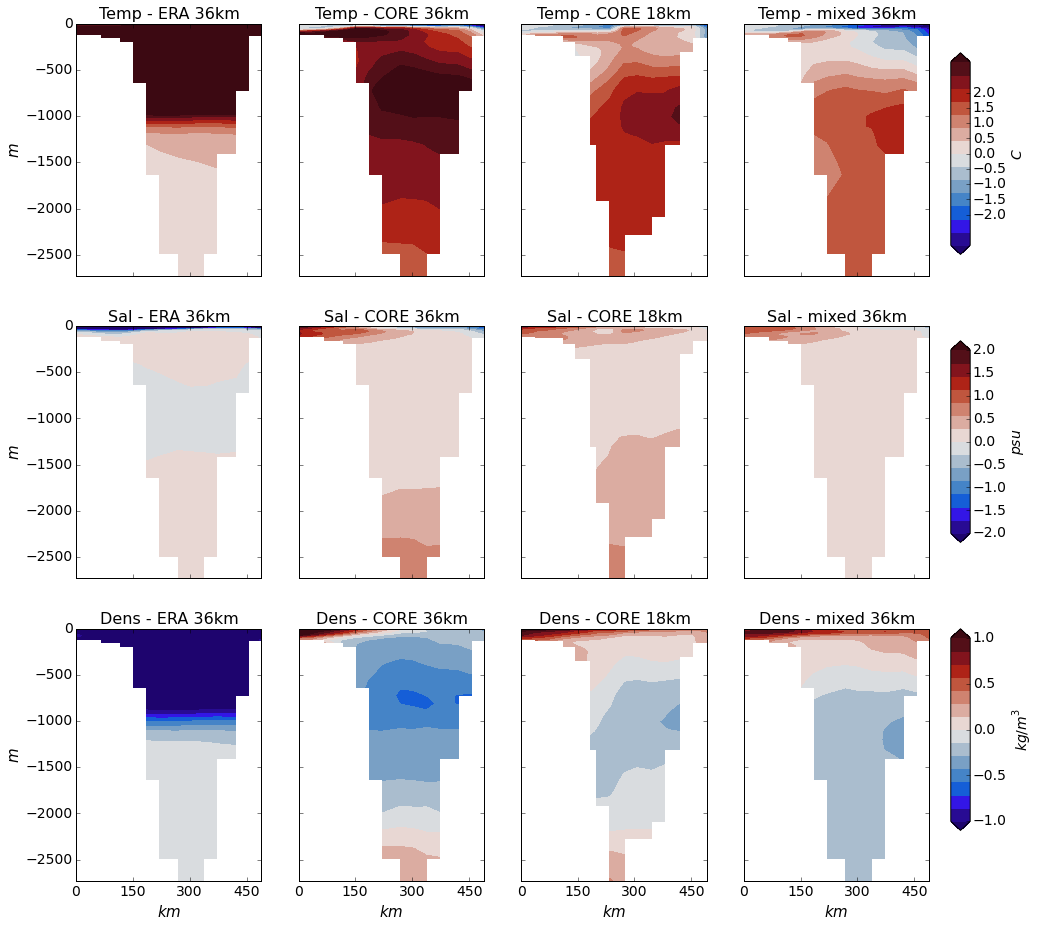

In [202]:
comp_diff_plot(comp_diff,woa,'fram')

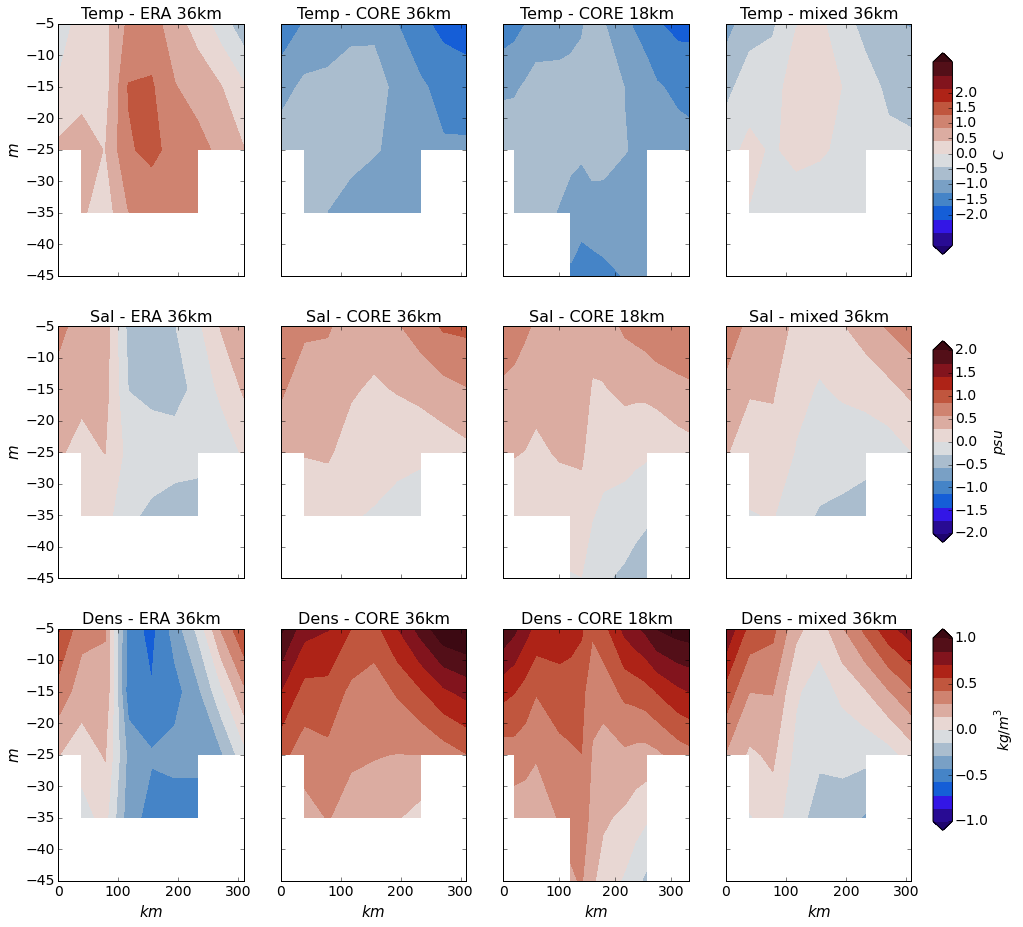

In [203]:
comp_diff_plot(comp_diff,woa,'bering')

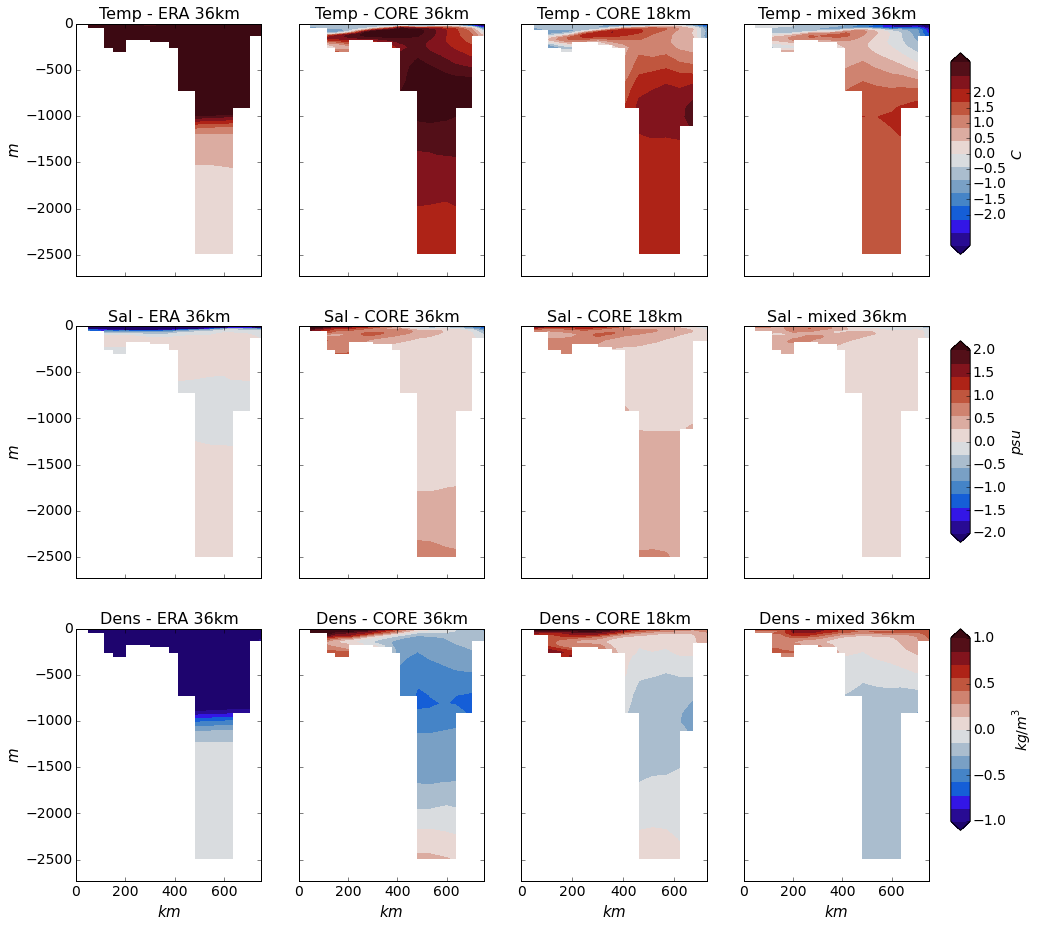

In [204]:
comp_diff_plot(comp_diff,woa,'barents')

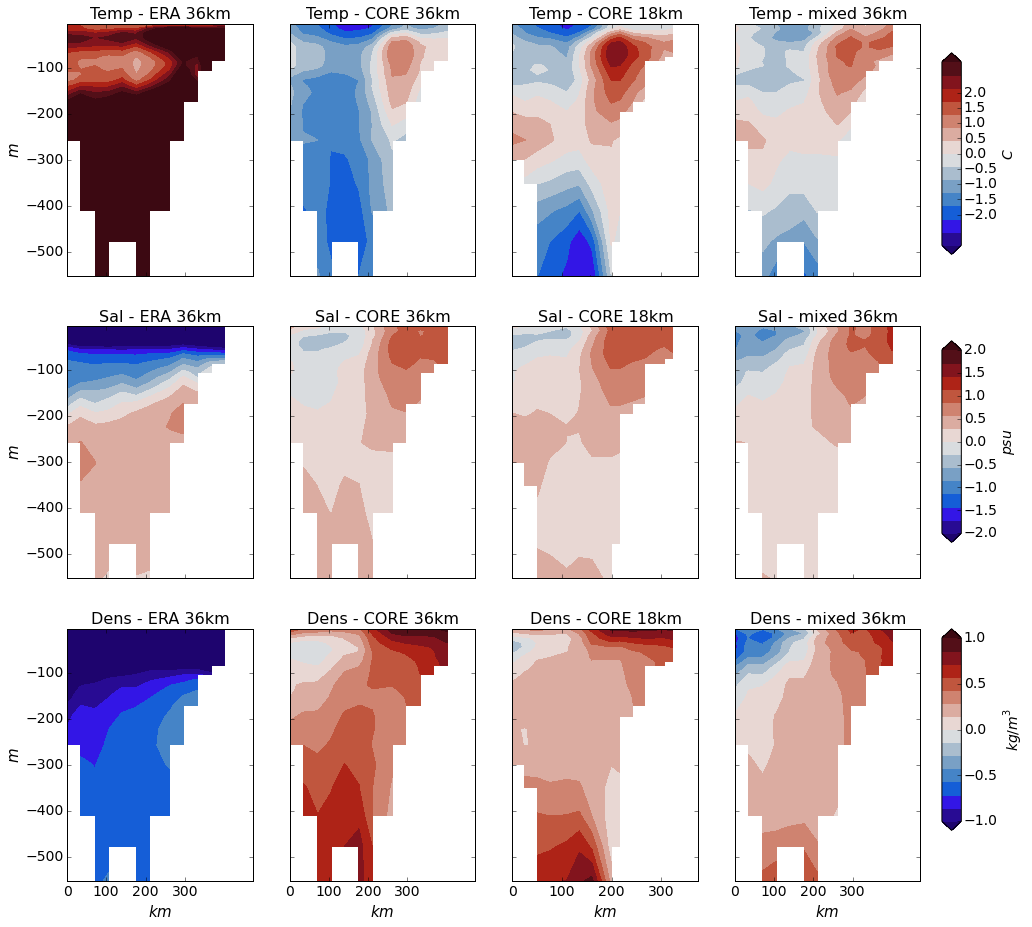

In [205]:
comp_diff_plot(comp_diff,woa,'davis')

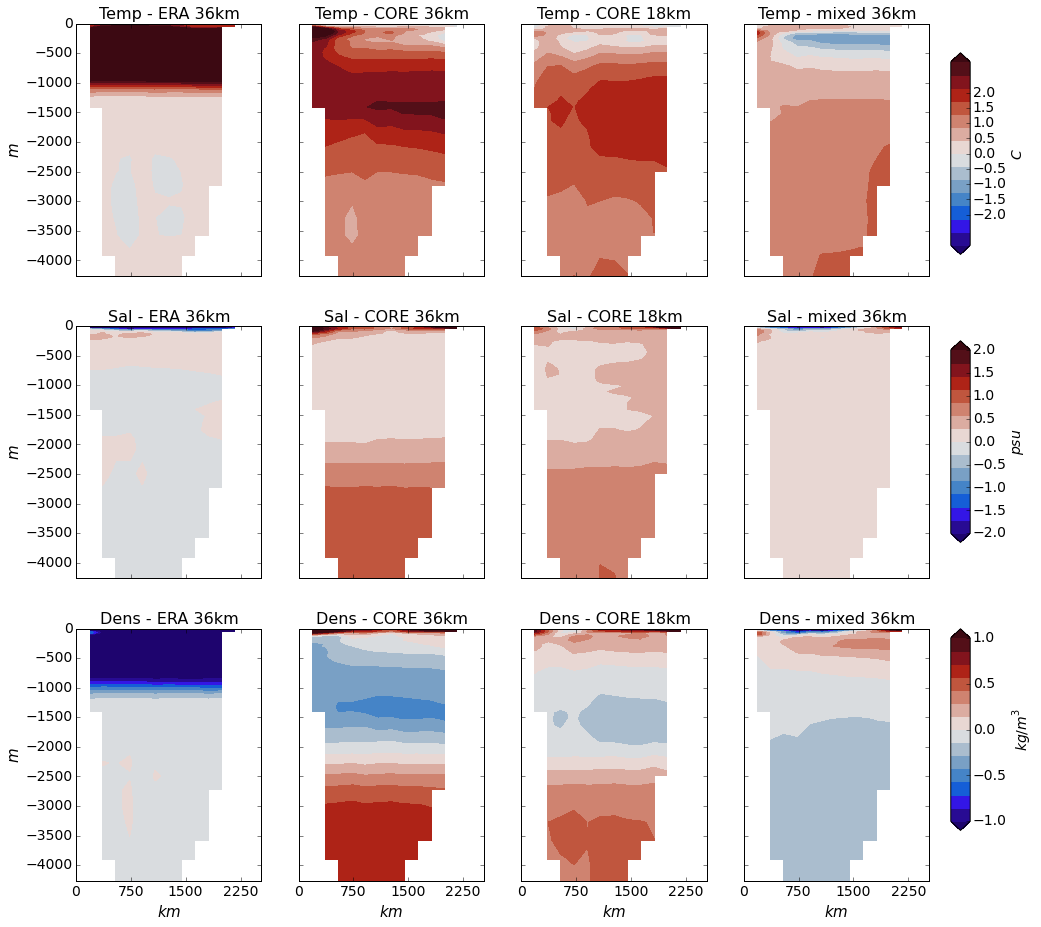

In [206]:
comp_diff_plot(comp_diff,woa,'arctic1')

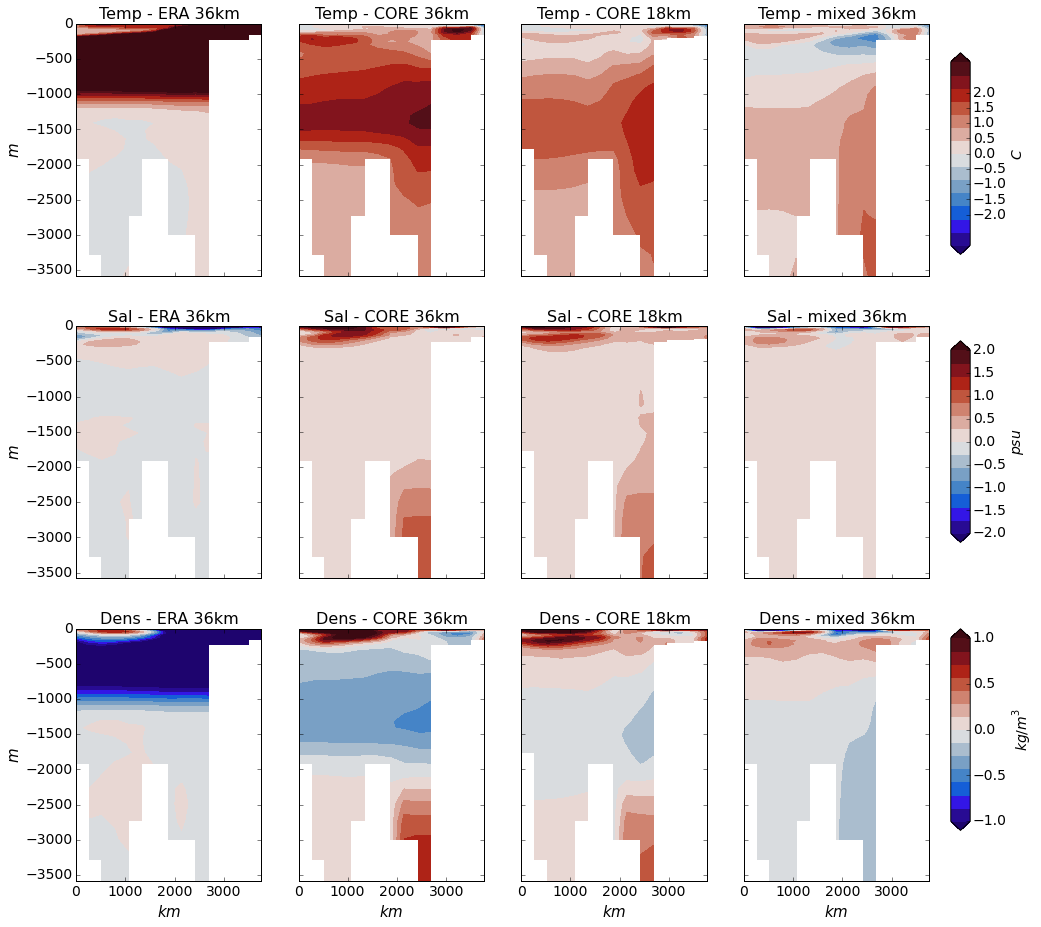

In [207]:
comp_diff_plot(comp_diff,woa,'arctic2')

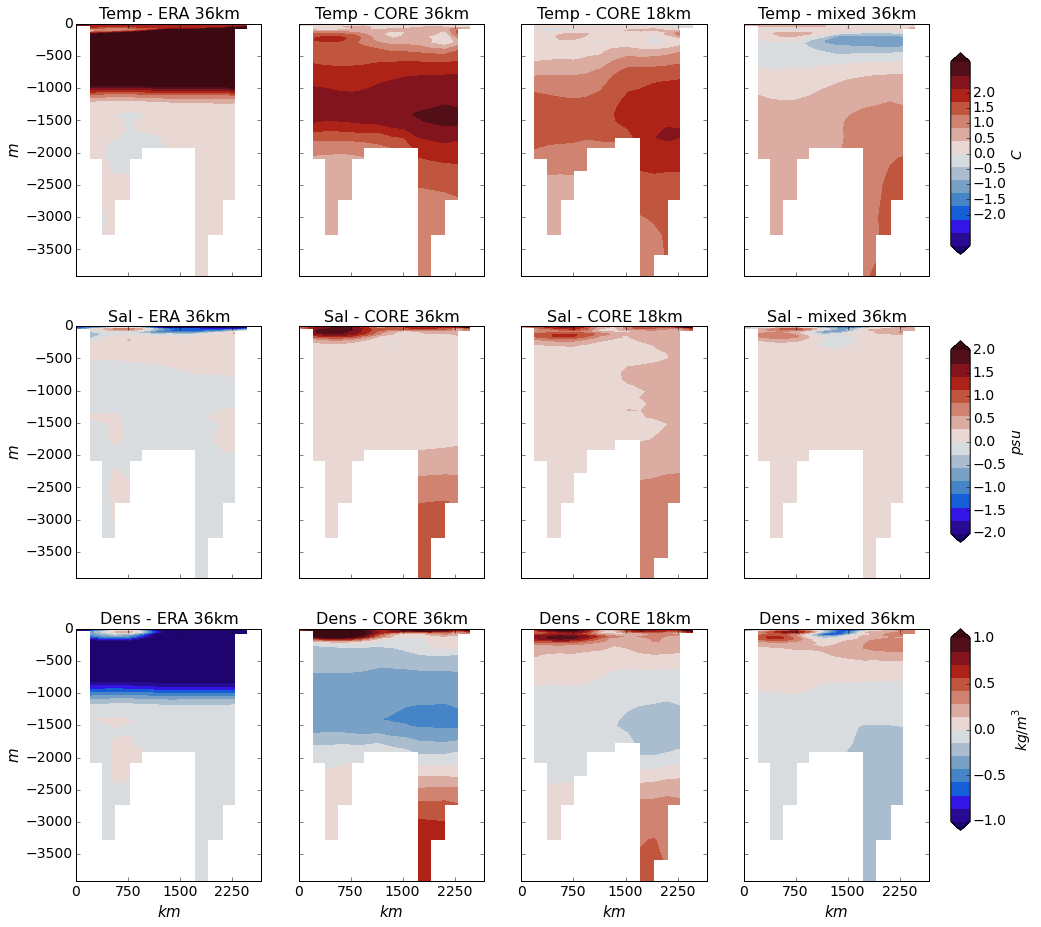

In [208]:
comp_diff_plot(comp_diff,woa,'arctic3')

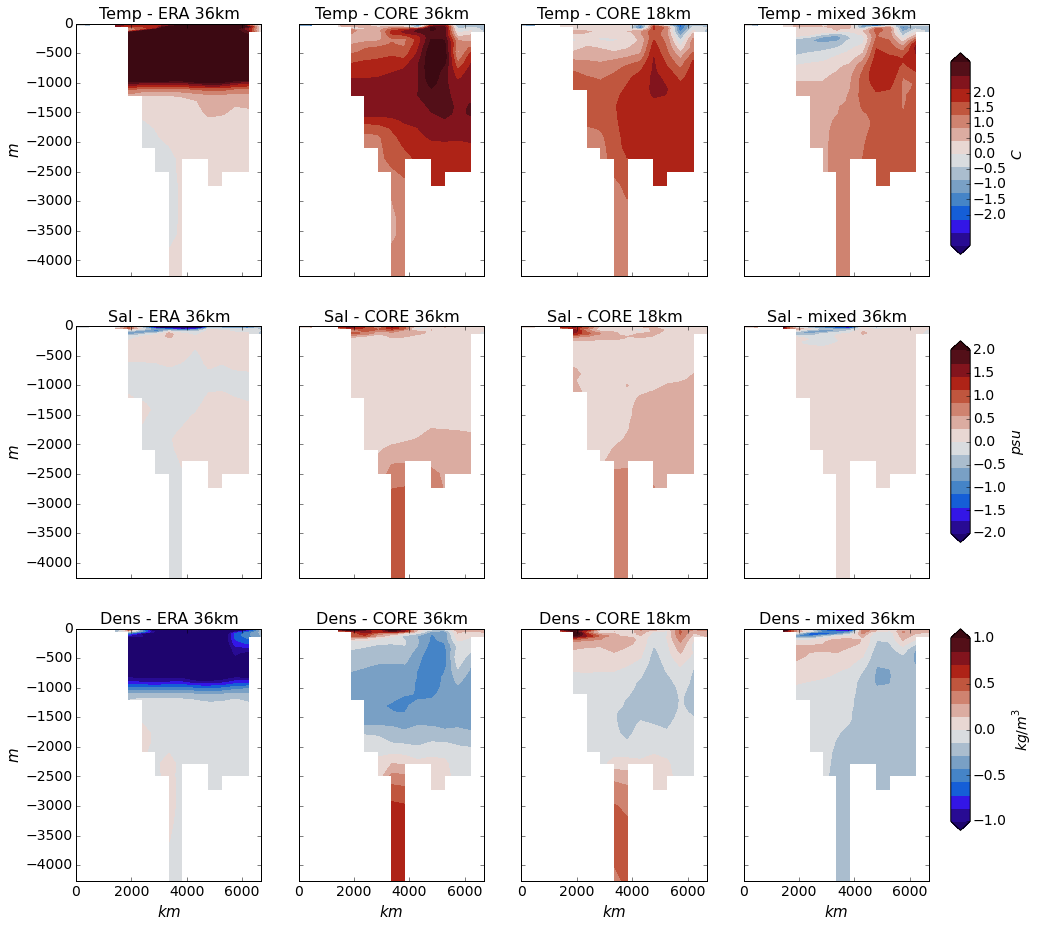

In [209]:
comp_diff_plot(comp_diff,woa,'arctic4')

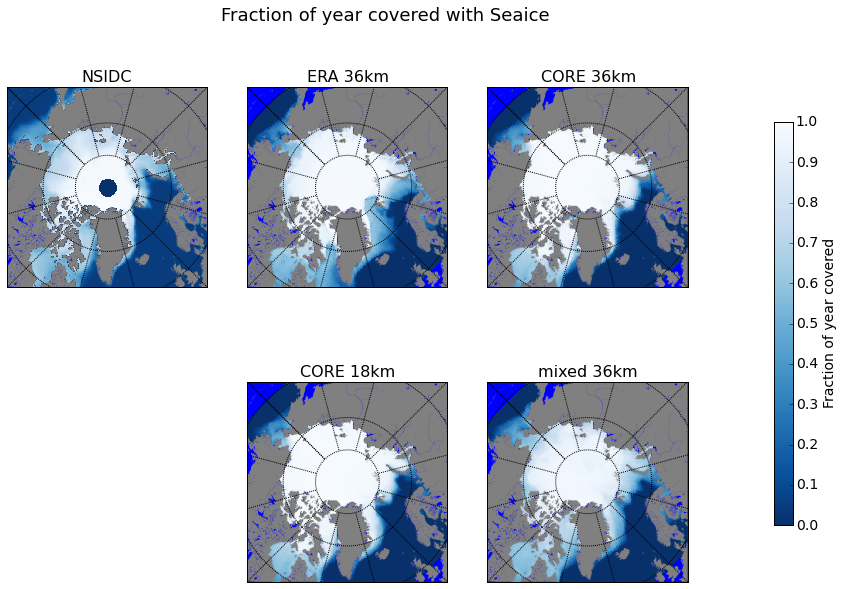

In [210]:
#comp_seaice = {0 : nsidc, 1 : ERA_36, 2 : CORE_36 , 3 : CORE_36 , 4 : CORE_18 , 5 : CORE_9_nogm}
comp_seaice = {0 : nsidc, 1 : ERA_36, 2 : CORE_36 , 3 : CORE_36 , 4 : CORE_18 , 5 : mixed_36}
def basemap_seaice(data_comp):
    lat_ts=90.0
    lat_0=90.0
    lon_0=-45.0
    sgn=1
    width=7000000.
    height=7000000.0
    
    ind = 0
    fig, axes = plt.subplots(2,3)
    for data in data_comp:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='h',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='blue')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='blue')
        x,y=m(data_comp[data].lon,data_comp[data].lat)
        datam = np.nanmean(data_comp[data].seaice['SIarea'][:,:,:],axis=0)
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=matplotlib.cm.Blues_r)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title(data_comp[data].title,fontsize=16)
        ind += 1
    fig.suptitle("Fraction of year covered with Seaice",x=1.,y=2.2,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'Fraction of year covered')
    plt.delaxes(axes.flat[3])
    fig.subplots_adjust(right=1.7,top=2.)
    fig.savefig('/noc/users/am8e13/Figures/basemap_seaice',dpi=dpires, bbox_inches='tight')
basemap_seaice(comp_seaice)

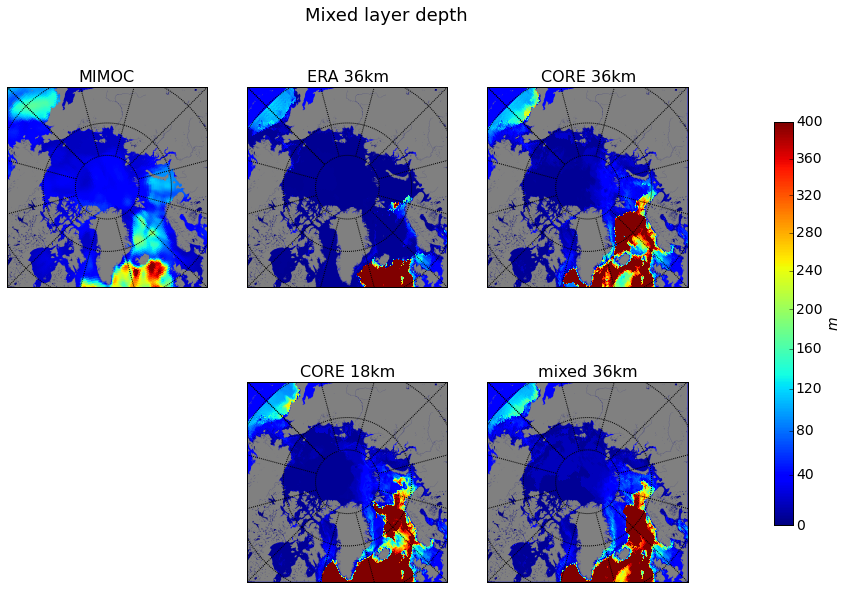

In [211]:
#comp_mxld = {0 : mix , 1 : ERA_36, 2 : CORE_36, 3 : CORE_36, 4 : CORE_18 , 5 : CORE_9_nogm }
comp_mxld = {0 : mix , 1 : ERA_36, 2 : CORE_36, 3 : CORE_36, 4 : CORE_18 , 5 : mixed_36 } 
def basemap_mxldepth(data_comp):
    lat_ts=90.0
    lat_0=90.0
    lon_0=-45.0
    sgn=1
    width=7000000.
    height=7000000.0
    vmin = 0
    vmax = 400
    ind = 0
    fig, axes = plt.subplots(2,3)
    for data in data_comp:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='h',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='blue')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='navy')
        x,y=m(data_comp[data].lon,data_comp[data].lat)
        datam = data_comp[data].mxldepth[2,:,:]
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=matplotlib.cm.jet,vmin=vmin,vmax=vmax,norm=matplotlib.colors.PowerNorm(gamma=9./10.))
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title(data_comp[data].title,fontsize=16)
        ind += 1
    fig.suptitle("Mixed layer depth",x=1.,y=2.2,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'$m$')
    plt.delaxes(axes.flat[3])
    fig.subplots_adjust(right=1.7,top=2.)
    fig.savefig('/noc/users/am8e13/Figures/basemap_mxldepth',dpi=dpires, bbox_inches='tight')
basemap_mxldepth(comp_mxld)

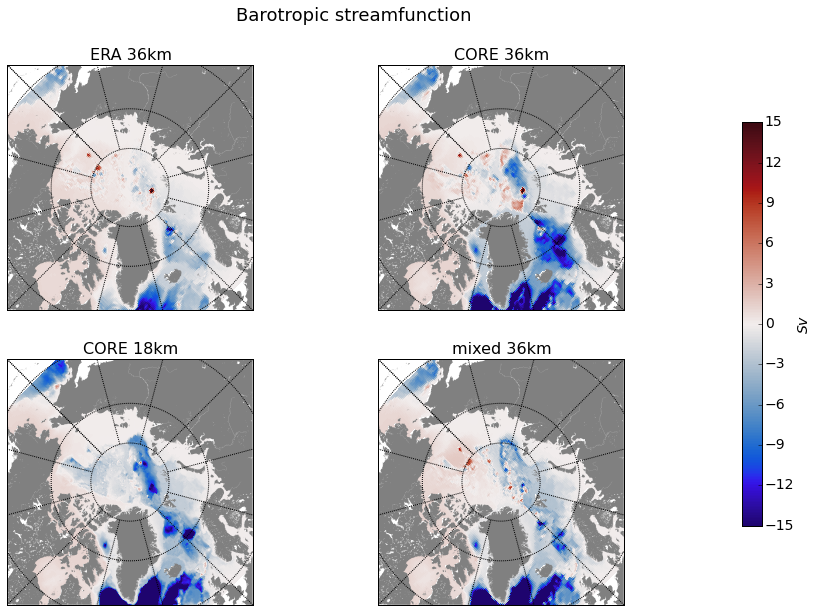

In [212]:
def basemap_barot(data_comp):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0
    sgn=1
    width=7000000. ; height=7000000.0
    vmin = -15 ; vmax = 15 ; ind = 0 ; cmap = cmocean.cm.freesurface
    fig, axes = plt.subplots(2,2)
    for data in data_comp:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='h',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='white')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='white')
        x,y=m(data_comp[data].lon,data_comp[data].lat)
        datam = data_comp[data].psi_ave[0:len(data_comp[data].Y),0:len(data_comp[data].X)]
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=cmap,vmin=vmin,vmax=vmax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title(data_comp[data].title,fontsize=16)
        ind += 1
    fig.suptitle("Barotropic streamfunction",x=1.,y=2.2,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'$Sv$')
    fig.subplots_adjust(right=1.7,top=2.)
    fig.savefig('/noc/users/am8e13/Figures/basemap_barostream',dpi=dpires, bbox_inches='tight')
    
basemap_barot(comp_diff)

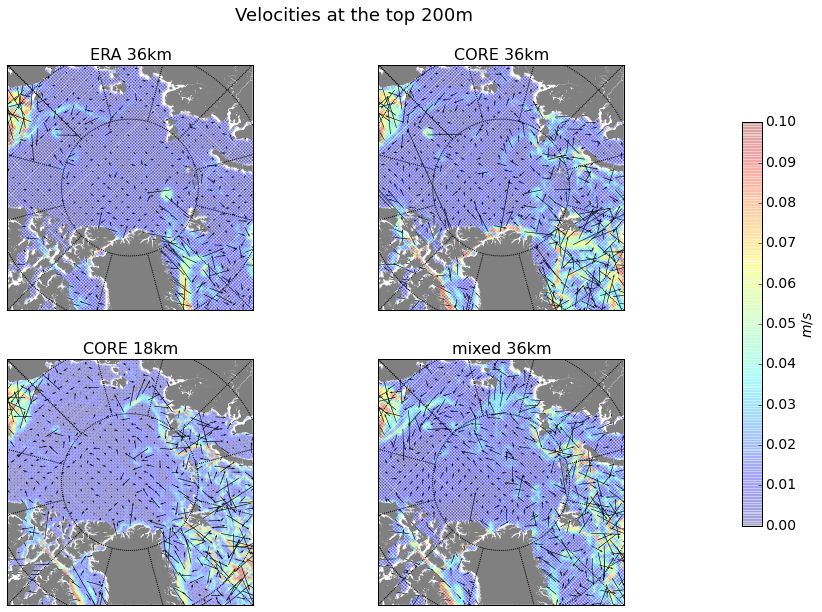

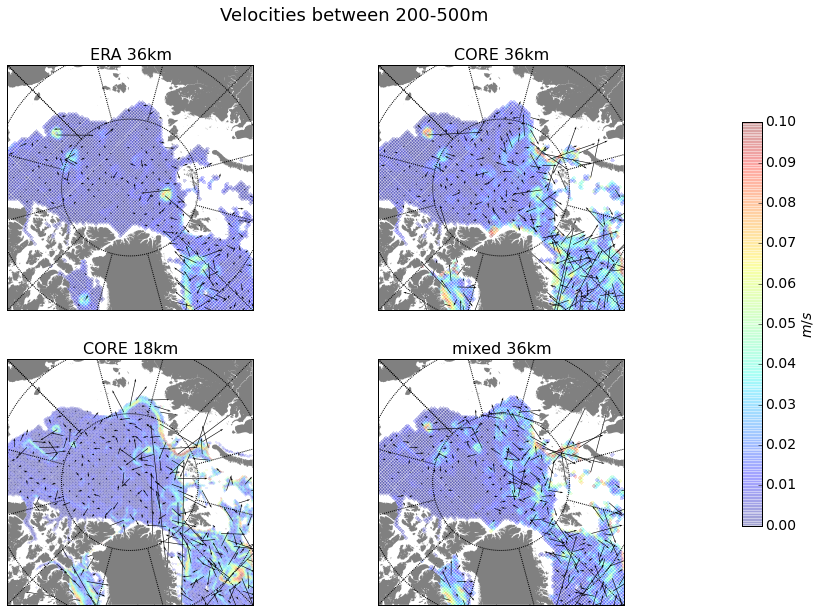

In [213]:
def basemap_arrows(data_comp,region):
    nzd = {'upper' : range(0,18,1), 'lower' : range(18,24,1)}
    nztitle = {'upper' : 'at the top 200m', 'lower' : 'between 200-500m'}
    nz = nzd[region]
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0
    sgn=1
    width=4000000. ; height=4000000.0
    vmin = 0 ; vmax = 0.1 ; ind = 0 ; cmap = matplotlib.cm.jet
    fig, axes = plt.subplots(2,2)
    for data in data_comp:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='h',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='white')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='white')
        x,y=m(data_comp[data].lon,data_comp[data].lat)
        datam = np.sqrt(np.nanmean(data_comp[data].U[nz,0:len(data_comp[data].Y),0:len(data_comp[data].X)],axis=0)**2 + 
                np.nanmean(data_comp[data].V[nz,0:len(data_comp[data].Y),0:len(data_comp[data].X)],axis=0)**2 )
        sitm = np.ma.masked_where(np.isnan(datam),datam)  
        alphad = {36 : 0.2 , 18 : 0.1 , 9 : 0.05}
        CS=m.pcolormesh(x,y,sitm,cmap=cmap,vmin=vmin,vmax=vmax,alpha=alphad[data_comp[data].res])        
        nx = len(data_comp[data].X)
        ny = len(data_comp[data].Y)
        datares = { 36 : 1 , 18 : 2 , 9 : 4}
        nq = 4*datares[data_comp[data].res]
        m.quiver(x[::nq,::nq],y[::nq,::nq],np.nanmean(data_comp[data].U[nz,0:ny:nq,0:nx:nq],axis=0),
                 np.nanmean(data_comp[data].V[nz,0:ny:nq,0:nx:nq],axis=0),scale=0.4)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title(data_comp[data].title,fontsize=16)
        ind += 1
    fig.suptitle("Velocities "+nztitle[region],x=1.,y=2.2,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'$m/s$')
    fig.subplots_adjust(right=1.7,top=2.)
    
basemap_arrows(comp_diff,'upper')
basemap_arrows(comp_diff,'lower')

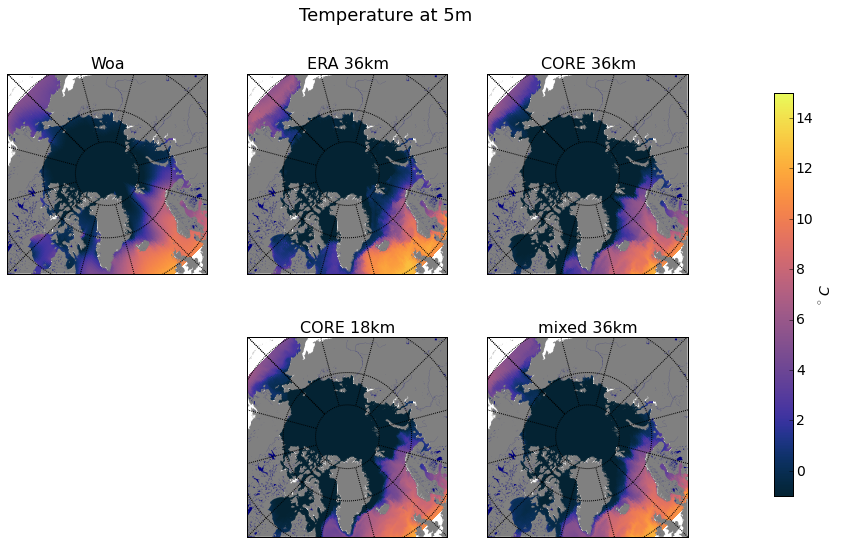

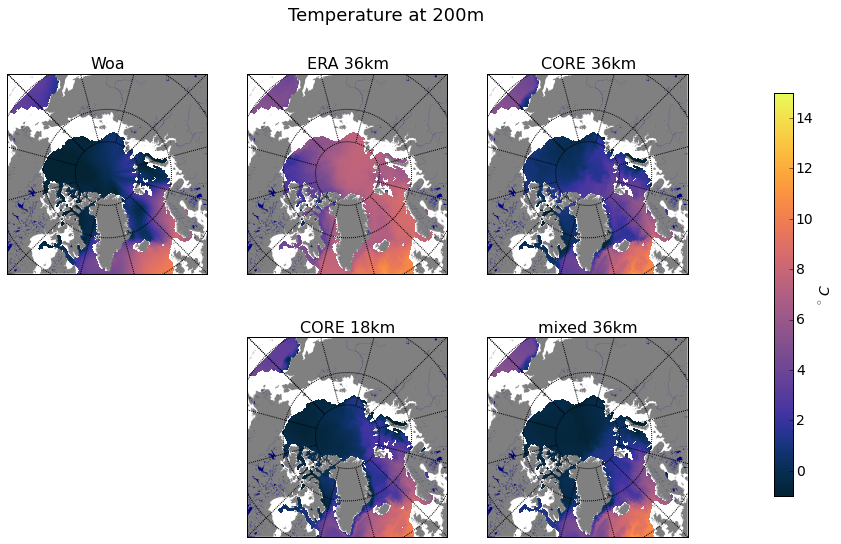

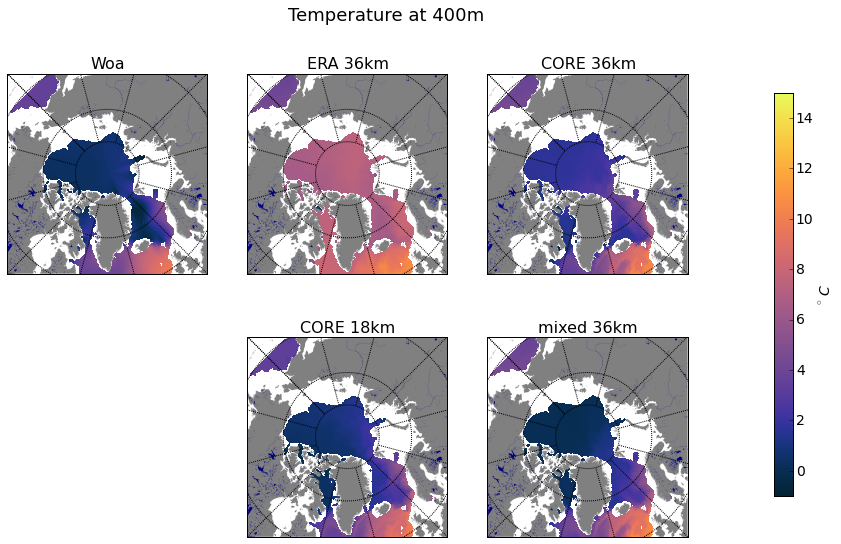

In [214]:
#comp_all = {0 : woa , 1 : ERA_36, 2 : CORE_36, 3 : CORE_36, 4 : CORE_18 , 5 : CORE_9_nogm }
comp_all = {0 : woa , 1 : ERA_36, 2 : CORE_36, 3 : CORE_36, 4 : CORE_18 , 5 : mixed_36 }
def basemap_temperature(data_comp,met):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;
    sgn=1
    width=7000000. ; height=7000000.0 ;
    vmin = -1 ; vmax = 15 ;
    ind = 0
    metd = { 5 : 0 , 200 : 16 , 400 : 21 }
    mm = metd[met]

    fig, axes = plt.subplots(2,3)
    for data in data_comp:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='h',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='white')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='navy')
        x,y=m(data_comp[data].lon,data_comp[data].lat)
        datam = data_comp[data].T[mm,:,:]
        sitm = np.ma.masked_where(np.isnan(datam),datam)

        CS=m.pcolormesh(x,y,sitm,cmap=cmocean.cm.temp,vmin=vmin,vmax=vmax)#,ps,cmap=cm.jet,extend='max')
        m.drawparallels(np.arange(-80.,81.,15.))#,labels=[1,0,0,0])
        m.drawmeridians(np.arange(-180.,181.,30.))#,labels=[0,0,1,1])
        #m.drawcoastlines()
        axes.flat[ind].set_title(data_comp[data].title,fontsize=16)
        ind += 1
    fig.suptitle("Temperature at "+str(met)+"m",x=1.,y=2.0,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.3, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'$^{\circ}C$')
    plt.delaxes(axes.flat[3])
    fig.subplots_adjust(right=1.7,top=1.8)
    #fig.savefig('/noc/users/am8e13/Figures/basemap_temp_'+str(met),dpi=dpires, bbox_inches='tight')

basemap_temperature(comp_all,5)
basemap_temperature(comp_all,200)
basemap_temperature(comp_all,400)

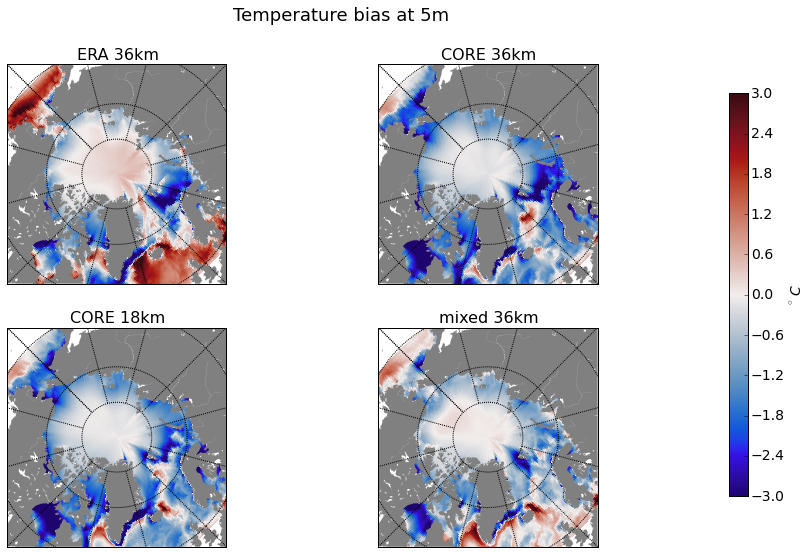

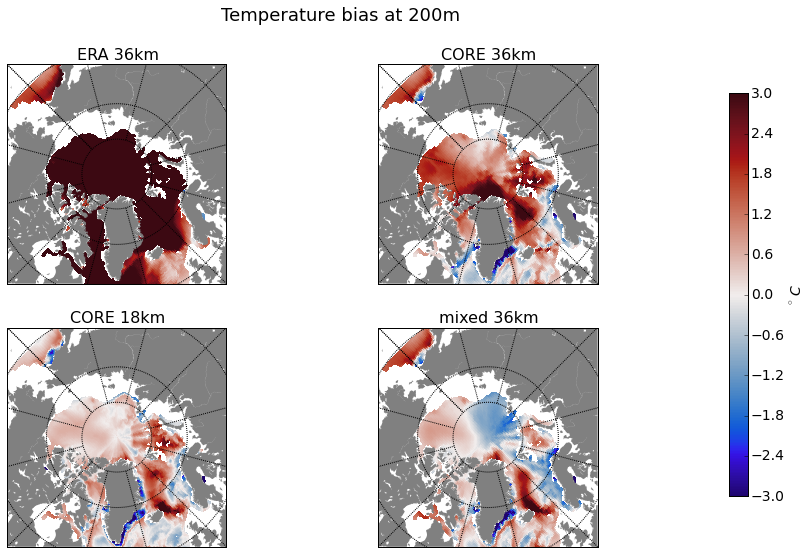

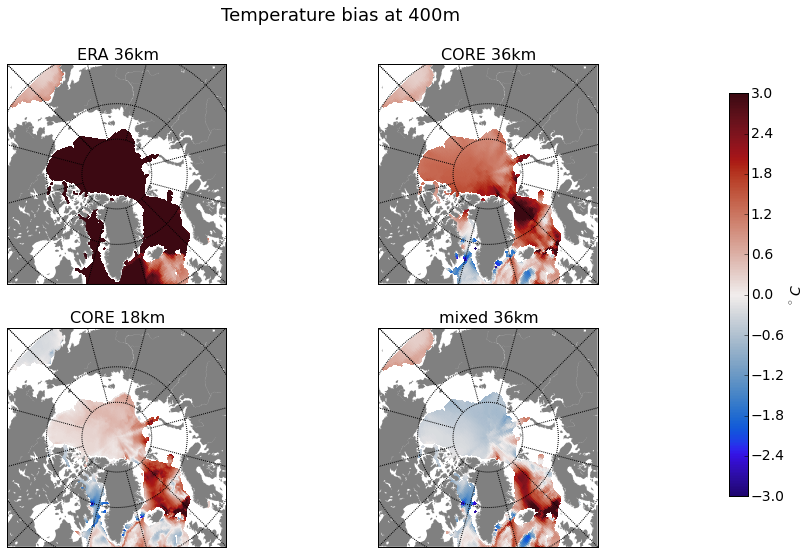

In [215]:
def basemap_temperature_diff(data_comp,diff,met):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;
    sgn=1
    width=7000000. ; height=7000000.0 ;
    vmin = -3 ; vmax = 3 ;
    ind = 0
    metd = { 5 : 0 , 200 : 16 , 400 : 21 }
    mm = metd[met]
    

    fig, axes = plt.subplots(2,2)
    for data in data_comp:
        if data_comp[data].res == 36:
            diffT = np.array(diff.T)
        elif data_comp[data].res == 18:
            diffT = np.array(diff.T18)
        elif data_comp[data].res == 9:
            diffT = np.array(diff.T9)
            
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='white')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='white')
        x,y=m(data_comp[data].lon,data_comp[data].lat)
        datam = data_comp[data].T[mm,:,:] - diffT[mm,:,:]
        sitm = np.ma.masked_where(np.isnan(datam),datam)

        CS=m.pcolormesh(x,y,sitm,cmap=cmocean.cm.freesurface,vmin=vmin,vmax=vmax)#,ps,cmap=cm.jet,extend='max')
        m.drawparallels(np.arange(-80.,81.,15.))#,labels=[1,0,0,0])
        m.drawmeridians(np.arange(-180.,181.,30.))#,labels=[0,0,1,1])
        #m.drawcoastlines()
        axes.flat[ind].set_title(data_comp[data].title,fontsize=16)
        ind += 1
    fig.suptitle("Temperature bias at "+str(met)+"m",x=1.,y=2.0,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.3, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'$^{\circ}C$')
    fig.subplots_adjust(right=1.7,top=1.8)
    #fig.savefig('/noc/users/am8e13/Figures/basemap_temp_'+str(met)+'_diff',dpi=dpires, bbox_inches='tight')

basemap_temperature_diff(comp_diff,woa,5)
basemap_temperature_diff(comp_diff,woa,200)
basemap_temperature_diff(comp_diff,woa,400)

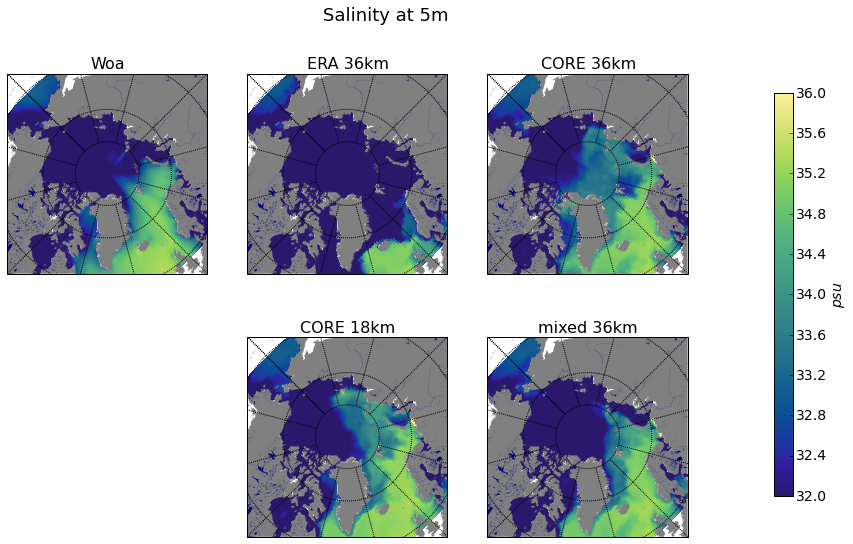

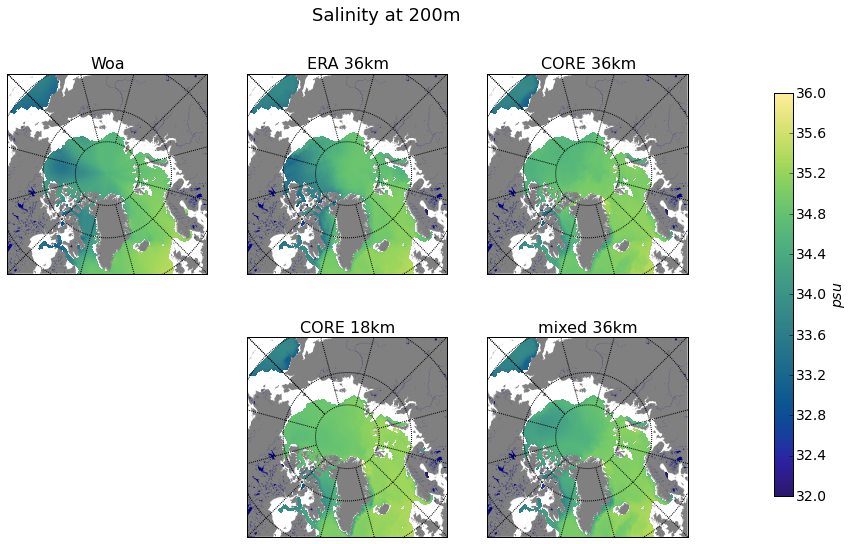

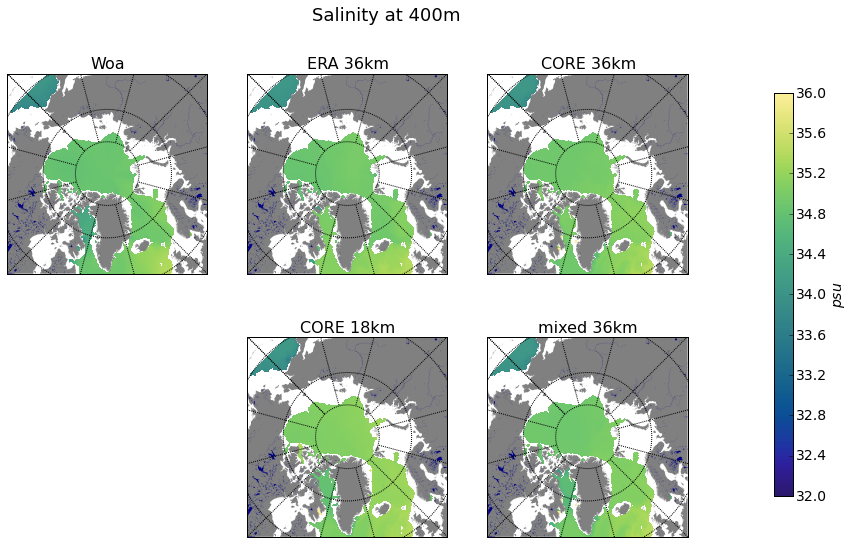

In [216]:
#comp_all = {0 : woa , 1 : ERA_36, 2 : CORE_36, 3 : CORE_36, 4 : CORE_18 , 5 : CORE_9_nogm }
comp_all = {0 : woa , 1 : ERA_36, 2 : CORE_36, 3 : CORE_36, 4 : CORE_18 , 5 : mixed_36 }
def basemap_salinity(data_comp,met):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;
    sgn=1
    width=7000000. ; height=7000000.0 ;
    vmin = 32 ; vmax = 36 ;
    ind = 0
    metd = { 5 : 0 , 200 : 16 , 400 : 21 }
    mm = metd[met]
    
    fig, axes = plt.subplots(2,3)
    for data in data_comp:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='h',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='white')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='navy')
        x,y=m(data_comp[data].lon,data_comp[data].lat)
        datam = data_comp[data].S[mm,:,:]
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=cmocean.cm.salt,vmin=vmin,vmax=vmax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        #m.drawcoastlines()
        axes.flat[ind].set_title(data_comp[data].title,fontsize=16)
        ind += 1
    fig.suptitle("Salinity at "+str(met)+"m",x=1.,y=2.,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.3, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'$psu$')
    plt.delaxes(axes.flat[3])
    fig.subplots_adjust(right=1.7,top=1.8)
    fig.savefig('/noc/users/am8e13/Figures/basemap_salt_'+str(met),dpi=dpires, bbox_inches='tight')

    
basemap_salinity(comp_all,5)
basemap_salinity(comp_all,200)
basemap_salinity(comp_all,400)

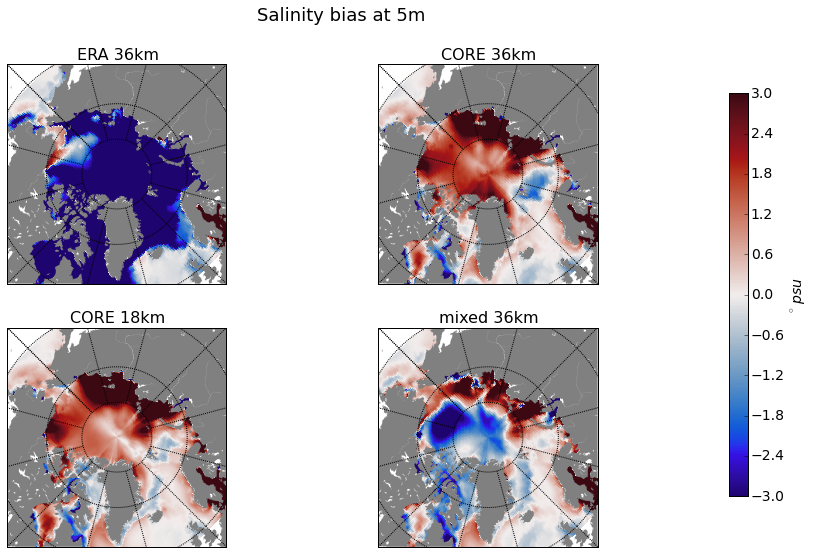

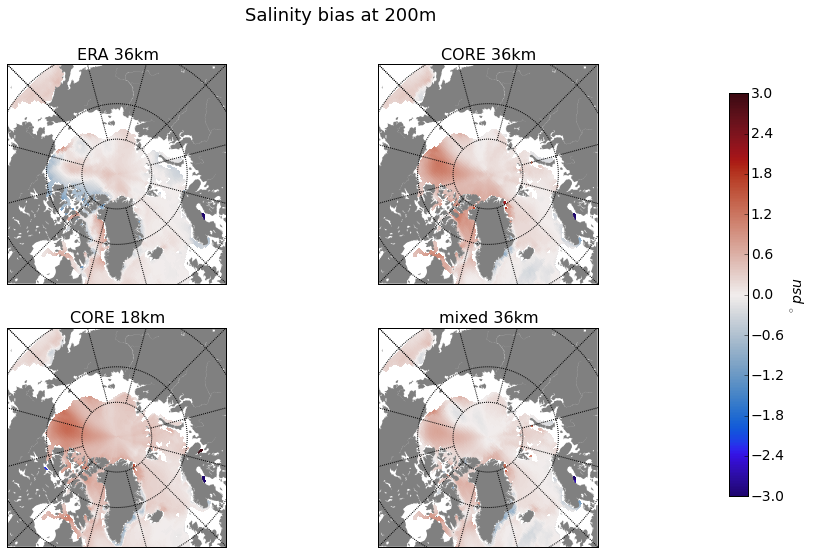

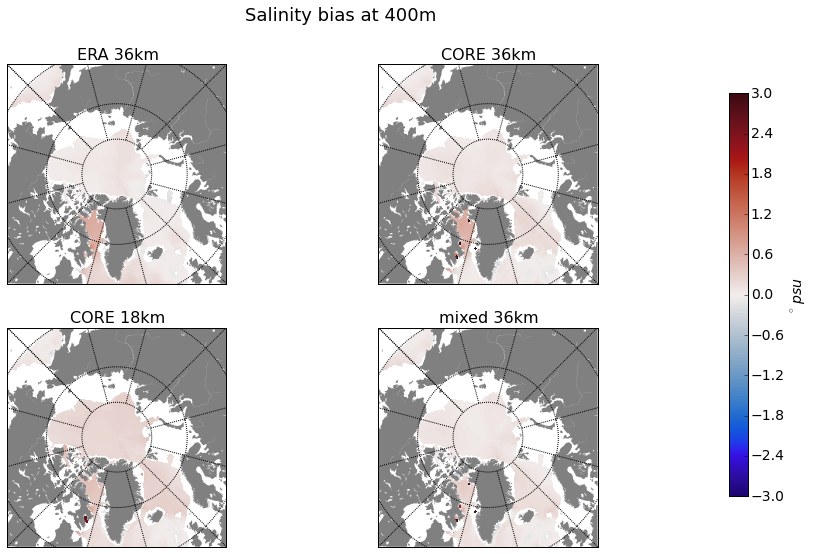

In [217]:
def basemap_salinity_diff(data_comp,diff,met):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;
    sgn=1
    width=7000000. ; height=7000000.0 ;
    vmin = -3 ; vmax = 3 ;
    ind = 0
    metd = { 5 : 0 , 200 : 16 , 400 : 21 }
    mm = metd[met]
    

    fig, axes = plt.subplots(2,2)
    for data in data_comp:
        if data_comp[data].res == 36:
            diffS = np.array(diff.S)
        elif data_comp[data].res == 18:
            diffS = np.array(diff.S18)
        elif data_comp[data].res == 9:
            diffS = np.array(diff.S9)
            
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='white')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='white')
        x,y=m(data_comp[data].lon,data_comp[data].lat)
        datam = data_comp[data].S[mm,:,:] - diffS[mm,:,:]
        sitm = np.ma.masked_where(np.isnan(datam),datam)

        CS=m.pcolormesh(x,y,sitm,cmap=cmocean.cm.freesurface,vmin=vmin,vmax=vmax)#,ps,cmap=cm.jet,extend='max')
        m.drawparallels(np.arange(-80.,81.,15.))#,labels=[1,0,0,0])
        m.drawmeridians(np.arange(-180.,181.,30.))#,labels=[0,0,1,1])
        #m.drawcoastlines()
        axes.flat[ind].set_title(data_comp[data].title,fontsize=16)
        ind += 1
    fig.suptitle("Salinity bias at "+str(met)+"m",x=1.,y=2.0,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.3, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'$^{\circ}psu$')
    fig.subplots_adjust(right=1.7,top=1.8)
    #fig.savefig('/noc/users/am8e13/Figures/basemap_salt_'+str(met)+'_diff',dpi=dpires, bbox_inches='tight')

basemap_salinity_diff(comp_diff,woa,5)
basemap_salinity_diff(comp_diff,woa,200)
basemap_salinity_diff(comp_diff,woa,400)

## Monitor diagnostics

In this session we use monitor diagnostic to study the model spinup

In [11]:
dpires = 300

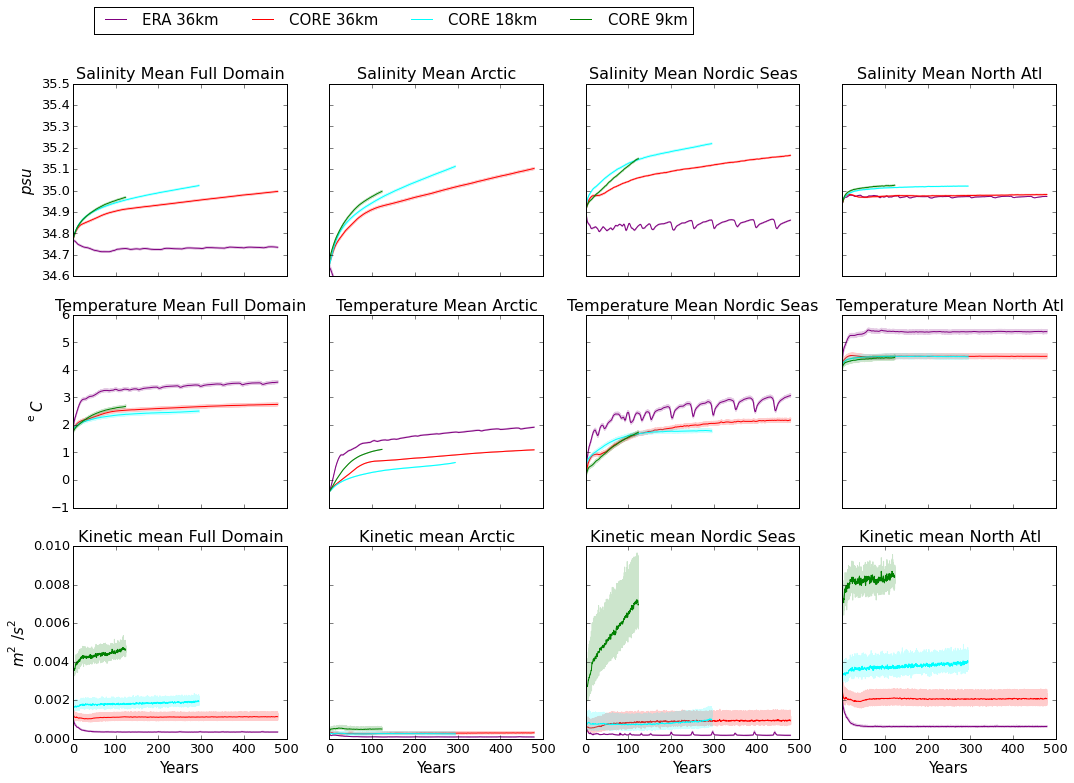

In [12]:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def plot_dynSt_titles():
    titles = {'theta_mean' : 'Temperature Mean', 'theta_min' : 'Temperature Min',\
              'theta_max' :  'Temperature Max', 'eta_mean' : 'ETA mean', 'eta_max' : 'ETA max',\
              'eta_min' : 'ETA min', 'salt_mean' : 'Salinity Mean' , 'salt_max' : 'Salinity Max',\
              'salt_min' : 'Salinity Min' , 'sss_mean': 'SSS mean' ,'sss_max' : 'SSS max',\
              'sss_min' : 'SSS min', 'sst_mean' : 'SST mean', 'sst_max' : 'SST max' ,'sst_min' : 'SST min',\
              'vvel_mean' : 'V mean', 'vvel_max' : 'V max' , 'vvel_min' : 'V min', 'uvel_mean' : 'U mean',\
              'uvel_max' : 'U max', 'uvel_min' : 'U min', 'ke_mean' : 'Kinetic mean', 'ke_max' : 'Kinetic max',\
              'ke_vol' : 'Kinetic volume', 'seaice_area_max' : 'Seaice area max',\
              'seaice_area_min' : 'Seaice area min', 'seaice_area_mean' : 'Seaice area mean', \
              'seaice_heff_max' : 'Seaice thickness max', 'seaice_heff_min' : 'Seaicea thickness max', \
              'seaice_heff_mean' : 'Seaice thickness mean', 'time_seconds' : 'Time seconds' , \
                'time_years' : 'Time years'}
    unity = {'theta_mean' : r'$^{\circ}C$', 'theta_min' : r'$^{\circ}C$', 'theta_max' :  r'$^{\circ}C$', \
                 'eta_mean' : r'$m$', 'eta_max' : r'$m$', 'eta_min' : r'$m$', 'salt_mean' : r'$psu$' , \
                 'salt_max' : r'$psu$' , 'salt_min' : r'$psu$' , 'sss_mean': r'$psu$' , \
                 'sss_max' : r'$psu$', 'sss_min' : r'$psu$', 'sst_mean' : r'$^{\circ}C$', \
                 'sst_max' : r'$^{\circ}C$' , 'sst_min' : r'$^{\circ}C$', 'vvel_mean' : r'$m/s$', \
                 'vvel_max' : r'$m/s$' , 'vvel_min' : r'$m/s$', 'uvel_mean' : r'$m/s$', 'uvel_max' : r'$m/s$', \
                 'uvel_min' : r'$m/s$', 'ke_mean' : r'$m^2/s^2$', \
                 'ke_max' : r'$m^2/s^2$', 'ke_vol' : r'$m^2/s^2$', 'seaice_area_max' : '%', \
                 'seaice_area_min' : '%', 'seaice_area_mean' : '%', \
                 'seaice_heff_max' :  r'$m$', 'seaice_heff_min' :  r'$m$', \
                 'seaice_heff_mean' :  r'$m$', 'time_seconds' : 's' , \
                 'time_years' : 'Years'}
    axistick = {'theta_mean' : [0,500,-1,6], 'theta_min' : [0,500,-1,6], 'theta_max' :  [0,500,-1,6], \
                 'eta_mean' : r'$m$', 'eta_max' : r'$m$', 'eta_min' : r'$m$', 'salt_mean' : [0,500,34.6,35.5] , \
                 'salt_max' : [0,500,34.6,35.5] , 'salt_min' : [0,500,34.6,35.5] , 'sss_mean': [0,500,34.6,35.5] , \
                 'sss_max' : [0,500,34.6,35.5], 'sss_min' : [0,500,34.6,35.5], 'sst_mean' : [0,500,-1,6], \
                 'sst_max' : [0,500,-1,6] , 'sst_min' : [0,500,-1,6], 'vvel_mean' : [0,500,-0.002,0.002] , \
                 'vvel_max' : [0,500,-0.001,0.001] , 'vvel_min' : [0,500,-0.001,0.001] , \
                 'uvel_mean' : [0,500,-0.002,0.002] ,'uvel_max' : [0,500,-0.001,0.001] , \
                 'uvel_min' : [0,500,-0.001,0.001] , 'ke_mean' : [0,500,0,0.01], \
                 'ke_max' : [0,500,0,0.005], 'ke_vol' : [0,500,0,0.005], 'seaice_area_max' : '%', \
                 'seaice_area_min' : '%', 'seaice_area_mean' : '%', \
                 'seaice_heff_max' :  r'$m$', 'seaice_heff_min' :  r'$m$', \
                 'seaice_heff_mean' :  r'$m$', 'time_seconds' : 's' , \
                 'time_years' : 'Years'}
    return titles, unity, axistick

def plot_dynSt(monitor_list,var_list,reg,row=2):
    # this function is meant to plot monitor variables   
    titles, unity, axistick = plot_dynSt_titles()
    col = len(var_list)/2
    region = { 0 : 'Global' , 1 : 'Arctic' , 2 : 'Nordic Seas' , 3 : 'North Atl' }
    
    fig, axes = plt.subplots(row,col)
    ax_ind = 0
    for var in var_list:
        for mon in monitor_list:
            axes.flat[ax_ind].plot(monitor_list[mon].dataDyn['time_lv_years'],\
                                   monitor_list[mon].dataDyn[var][1:,reg,0],monitor_list[mon].color,alpha=0.2)
            axes.flat[ax_ind].plot(monitor_list[mon].dataDyn['time_lv_years'][0:-12*3],\
                                   runningMeanFast(monitor_list[mon].dataDyn[var][1:,reg,0],12*3)[0:-12*3],\
                                   monitor_list[mon].color,label=monitor_list[mon].title)
            axes.flat[ax_ind].set_title(titles[var]+' '+region[reg])
            axes.flat[ax_ind].set_ylabel(unity[var])
        ax_ind += 1
    plt.legend(bbox_to_anchor=(-2.2+(3-col), 2.1, 2.5 + col - 3, .3), ncol=4, mode="expand", borderaxespad=0.)
    fig.subplots_adjust(right=2.4,top=2.4)

def plot_dynSt_reg(monitor_list,var_list):
    offset = {'leg' : {3 : 3.5 , 2 : 2.2} , 'top' : {3 : 2.4 , 2 : 1.8}  }
    # this function is meant to plot monitor variables   
    titles, unity, axistick = plot_dynSt_titles()
    region = { 0 : 'Full Domain' , 1 : 'Arctic' , 2 : 'Nordic Seas' , 3 : 'North Atl' }
    col = len(region)
    row = len(var_list)
    fig, axes = plt.subplots(row,col,sharex=True,sharey='row')
    ax_ind = 0
    for var in var_list:
        for reg in region:
            for mon in monitor_list:
                axes.flat[ax_ind].plot(monitor_list[mon].dataDyn['time_lv_years'],\
                                   monitor_list[mon].dataDyn[var][1:,reg,0],monitor_list[mon].color,alpha=0.2)
                axes.flat[ax_ind].plot(monitor_list[mon].dataDyn['time_lv_years'][0:-12*3],\
                                   runningMeanFast(monitor_list[mon].dataDyn[var][1:,reg,0],12*3)[0:-12*3],\
                                   monitor_list[mon].color,label=monitor_list[mon].title)
                axes.flat[ax_ind].set_title(titles[var]+' '+region[reg],fontsize=16)
                if ax_ind % col == 0:
                    axes.flat[ax_ind].set_ylabel(unity[var],fontsize=15)
                if ax_ind > (col*2-1):
                    axes.flat[ax_ind].set_xlabel('Years',fontsize=15)
                axes.flat[ax_ind].axis(axistick[var])
            ax_ind += 1
    plt.setp([a.get_xticklabels() for a in axes.flat],fontsize=13)            
    plt.setp([a.get_yticklabels() for a in axes.flat],fontsize=13)            
    plt.setp([a.get_xticklabels() for a in axes[0, :]], visible=False)
    plt.setp([a.get_yticklabels() for a in axes[:, 1]], visible=False)
    plt.setp([a.get_yticklabels() for a in axes[:, 2]], visible=False)
    plt.setp([a.get_yticklabels() for a in axes[:, 3]], visible=False)

            
    plt.legend(bbox_to_anchor=(-3.5 , offset['leg'][row], 2.8, .3), ncol=4, mode="expand", borderaxespad=0.,fontsize=15)
    fig.subplots_adjust(right=2.4,top=offset['top'][row])
    #print('dynSt_'+str(var_list[1]))
    #fig.savefig('/noc/users/am8e13/Figures/dynSt_'+str(var_list[1]),dpi=dpires, bbox_inches='tight')
    fig.savefig('/noc/users/am8e13/Figures/dynSt_diag',dpi=dpires, bbox_inches='tight')

comp_diff = {1 : ERA_36, 2 : CORE_36 , 3 : CORE_18 , 4 : CORE_9_nogm ,}# 5 : mixed_36}
#plot_dynSt_reg(comp_diff,['salt_mean','theta_mean'])
#plot_dynSt_reg(comp_diff,['uvel_mean','vvel_mean','ke_mean'])
plot_dynSt_reg(comp_diff,['salt_mean','theta_mean','ke_mean'])

In [221]:
nt = 777600
for j in range(6):
    print 0 + j*nt

0
777600
1555200
2332800
3110400
3888000
